In [3]:
import os,sys
curr_path = os.getcwd()
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
# from memory import ReplayBuffer,NaivePrioritizedBuffer,NStepReplayBuffer
from common.plot import plot_rewards
from common.utils import save_results,make_dir

# multi-envs + 1 agent

In [4]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
import tianshou as ts
from common.multiprocessing_env import SubprocVecEnv
# from replay_buffer import PrioritizedReplayBuffer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# !pip install box2d-py # for box2d envs
def make_env(env_id,seed=1):
    if 'Pong' in env_id:
        env = make_atari(env_id)
        env = wrap_deepmind(env,episode_life=True)
        env = wrap_pytorch(env) 
    else:
        env = gym.make(env_id)
    if seed: env.seed(seed)
    return env
def init_envs_agent(cfg,nenv,seed=1):
    envs = ts.env.ShmemVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
#     envs = ts.env.SubprocVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
    if len(envs.observation_space[0].shape) == 1:
        state_dim = envs.observation_space[0].shape[0]
    else:
        state_dim = envs.observation_space[0].shape
        
    if 'Continuous' in cfg.model:
        cfg.max_act = envs.action_space[0].high[0]
        action_dim = envs.action_space[0].shape[0]
    else:
        action_dim = envs.action_space[0].n
        
    agent = Agent(state_dim,action_dim,cfg)
    return envs,agent
    
#<ImageToPyTorch<ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>

In [6]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)
    
    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
    buffer = []

    states = envs.reset()
    while i_frame < cfg.max_train_frames: #1500000: #
        
        ### interactive with environments ###
        for _ in range(cfg.n_multi_step):
            values, dists, actions = agent.sample(states)
            #if cfg.n_train_env == 1: actions = [actions]
            #actions = np.random.randint(6,size=cfg.n_train_env)
            next_states,rewards,dones,infos = envs.step(actions.cpu().detach().numpy())
            eps_rewards += rewards
            done_envs_ids = np.where(dones)[0]
            eps_frames += 1
            rewards = torch.as_tensor(rewards,device=cfg.device, dtype=torch.float32).unsqueeze(1)
            dones = torch.as_tensor(np.float32(dones), device=cfg.device).unsqueeze(1)
            buffer.append((values, dists, actions, rewards, dones))
            states = next_states
            i_frame += len(actions)
            
            ### recording historys ###
            if len(done_envs_ids) > 0:
                for r in eps_rewards[done_envs_ids]:
                    history['rewards'].append(r)
                    if history['ma_rewards']:
                        history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                    else:
                        history['ma_rewards'].append(r)
                for n in eps_frames[done_envs_ids]:
                    if history['frames']:
                        history['frames'].append(history['frames'][-1] + n)
                    else:
                        history['frames'].append(n)
                eps_frames[done_envs_ids] = 0
                eps_rewards[done_envs_ids] = 0
                states[done_envs_ids] = envs.reset(done_envs_ids)
        
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
                
        ### updating agent ###
        loss = agent.learn(buffer,next_states)
        if loss:
            history['loss'].append(loss)
        del buffer[:]
                    
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

In [7]:
def evaluate(cfg,envs,agent,render=False):
    envs.seed(1)
    print('Start Evaluating!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames']  = [],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_eval_env),np.zeros(cfg.n_eval_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0

    states = envs.reset()
    while i_frame < cfg.max_eval_frames:
        ### interactive with environments ###
        if render: envs.render()
        _,dist = agent.predict(states)
        actions = dist.sample()
        if cfg.n_eval_env == 1: actions = [actions]
        next_states,rewards,dones,infos = envs.step(actions.cpu().detach().numpy())
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        states = next_states
        i_frame += len(actions)

        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
            
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 10:
                prev_frame_verbose = history['frames'][-1]
                print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
    return history

In [8]:
def main():
    cfg = config()
    print(cfg.agent,cfg.env_id)
    
    envs,agent = init_envs_agent(cfg,cfg.n_train_env)
    history = train(cfg,envs,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(history,tag='train',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    eval_envs,agent = init_envs_agent(cfg,cfg.n_eval_env,seed=10)
    agent.load(path=cfg.model_path)
    history = evaluate(cfg,eval_envs,agent,render=False)
    save_results(history,tag='eval',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

## PongNoFrameskip-v4

In [9]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models`
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 5e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames 
        self.w_critic_loss = 0.5         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0003                 # learning rate
        self.gamma = 0.97              # discount rate of reward
        self.n_multi_step = 45          # number of steps of multi-step style gain 
        self.model = 'Discrete_CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C PongNoFrameskip-v4
Start Training!
20210719-112012
[20210719-112019: A2C] Episode:2: Frame:1514.0: Reward:-21.0: Loss:-0.1142
[20210719-112019: A2C] Episode:5: Frame:3860.0: Reward:-21.0: Loss:0.0142
[20210719-112020: A2C] Episode:9: Frame:7185.0: Reward:-20.0: Loss:0.0808
[20210719-112021: A2C] Episode:15: Frame:12410.0: Reward:-20.0: Loss:0.0317
[20210719-112026: A2C] Episode:17: Frame:14093.0: Reward:-21.0: Loss:0.0988
[20210719-112027: A2C] Episode:20: Frame:16592.0: Reward:-21.0: Loss:0.0739
[20210719-112027: A2C] Episode:22: Frame:18218.0: Reward:-21.0: Loss:0.0782
[20210719-112028: A2C] Episode:26: Frame:21632.0: Reward:-21.0: Loss:0.0369
[20210719-112029: A2C] Episode:28: Frame:23421.0: Reward:-20.0: Loss:-0.0973
[20210719-112030: A2C] Episode:31: Frame:26378.0: Reward:-18.0: Loss:0.1076
[20210719-112034: A2C] Episode:33: Frame:28184.0: Reward:-21.0: Loss:-0.0135
[20210719-112035: A2C] Episode:36: Frame:30627.0: Reward:-21.0: Loss:0.1661
[20210719-112036: A2C] Episode:38: F

[20210719-112224: A2C] Episode:261: Frame:219831.0: Reward:-21.0: Loss:0.0312
[20210719-112225: A2C] Episode:262: Frame:220858.0: Reward:-19.0: Loss:0.1131
[20210719-112225: A2C] Episode:263: Frame:221868.0: Reward:-19.0: Loss:0.1643
[20210719-112226: A2C] Episode:265: Frame:223650.0: Reward:-19.0: Loss:-0.0015
[20210719-112227: A2C] Episode:267: Frame:225444.0: Reward:-20.0: Loss:0.0282
[20210719-112228: A2C] Episode:269: Frame:227193.0: Reward:-19.0: Loss:0.1292
[20210719-112230: A2C] Episode:272: Frame:229780.0: Reward:-21.0: Loss:-0.0727
[20210719-112231: A2C] Episode:273: Frame:230781.0: Reward:-20.0: Loss:0.0696
[20210719-112232: A2C] Episode:275: Frame:232547.0: Reward:-20.0: Loss:0.0691
[20210719-112234: A2C] Episode:279: Frame:236250.0: Reward:-20.0: Loss:0.0796
[20210719-112235: A2C] Episode:281: Frame:238072.0: Reward:-20.0: Loss:-0.0645
[20210719-112236: A2C] Episode:283: Frame:239974.0: Reward:-19.0: Loss:-0.1701
[20210719-112237: A2C] Episode:285: Frame:241689.0: Reward:-

[20210719-112434: A2C] Episode:500: Frame:433817.0: Reward:-19.0: Loss:0.0447
[20210719-112436: A2C] Episode:502: Frame:435487.0: Reward:-20.0: Loss:0.0235
[20210719-112437: A2C] Episode:504: Frame:437385.0: Reward:-20.0: Loss:0.1270
[20210719-112439: A2C] Episode:506: Frame:439445.0: Reward:-20.0: Loss:0.1494
[20210719-112440: A2C] Episode:508: Frame:441280.0: Reward:-21.0: Loss:0.0109
[20210719-112441: A2C] Episode:510: Frame:443193.0: Reward:-21.0: Loss:0.1664
[20210719-112442: A2C] Episode:512: Frame:444940.0: Reward:-20.0: Loss:-0.0329
[20210719-112443: A2C] Episode:514: Frame:446934.0: Reward:-18.0: Loss:0.0072
[20210719-112443: A2C] Episode:515: Frame:448050.0: Reward:-19.0: Loss:0.1135
[20210719-112444: A2C] Episode:517: Frame:449675.0: Reward:-21.0: Loss:0.2370
[20210719-112445: A2C] Episode:519: Frame:451748.0: Reward:-19.0: Loss:0.0203
[20210719-112446: A2C] Episode:521: Frame:453562.0: Reward:-20.0: Loss:0.2324
[20210719-112448: A2C] Episode:523: Frame:455341.0: Reward:-21.

[20210719-112636: A2C] Episode:725: Frame:642696.0: Reward:-21.0: Loss:0.2907
[20210719-112638: A2C] Episode:727: Frame:644691.0: Reward:-20.0: Loss:0.1282
[20210719-112639: A2C] Episode:729: Frame:647201.0: Reward:-17.0: Loss:0.0475
[20210719-112640: A2C] Episode:732: Frame:649972.0: Reward:-21.0: Loss:0.2435
[20210719-112641: A2C] Episode:734: Frame:651787.0: Reward:-21.0: Loss:-0.1243
[20210719-112641: A2C] Episode:735: Frame:653008.0: Reward:-19.0: Loss:0.0094
[20210719-112642: A2C] Episode:736: Frame:654012.0: Reward:-20.0: Loss:0.0439
[20210719-112642: A2C] Episode:737: Frame:655083.0: Reward:-20.0: Loss:0.1532
[20210719-112644: A2C] Episode:739: Frame:657073.0: Reward:-20.0: Loss:0.0942
[20210719-112645: A2C] Episode:740: Frame:658108.0: Reward:-20.0: Loss:-0.0444
[20210719-112645: A2C] Episode:741: Frame:659197.0: Reward:-20.0: Loss:0.0227
[20210719-112646: A2C] Episode:742: Frame:660297.0: Reward:-20.0: Loss:0.0942
[20210719-112647: A2C] Episode:743: Frame:661333.0: Reward:-21

[20210719-112826: A2C] Episode:916: Frame:830478.0: Reward:-21.0: Loss:0.1289
[20210719-112826: A2C] Episode:918: Frame:832577.0: Reward:-20.0: Loss:0.1942
[20210719-112827: A2C] Episode:919: Frame:833683.0: Reward:-20.0: Loss:0.1569
[20210719-112828: A2C] Episode:921: Frame:835423.0: Reward:-21.0: Loss:-0.0588
[20210719-112830: A2C] Episode:923: Frame:837306.0: Reward:-19.0: Loss:0.0583
[20210719-112831: A2C] Episode:926: Frame:840626.0: Reward:-19.0: Loss:-0.1121
[20210719-112831: A2C] Episode:927: Frame:841966.0: Reward:-16.0: Loss:0.0802
[20210719-112833: A2C] Episode:928: Frame:842969.0: Reward:-21.0: Loss:0.0332
[20210719-112833: A2C] Episode:929: Frame:843999.0: Reward:-21.0: Loss:0.0905
[20210719-112834: A2C] Episode:931: Frame:845996.0: Reward:-20.0: Loss:-0.0885
[20210719-112836: A2C] Episode:934: Frame:848871.0: Reward:-21.0: Loss:-0.2504
[20210719-112837: A2C] Episode:936: Frame:851088.0: Reward:-20.0: Loss:-0.2628
[20210719-112839: A2C] Episode:939: Frame:854309.0: Reward:

[20210719-113009: A2C] Episode:1083: Frame:1011650.0: Reward:-18.0: Loss:-0.1371
[20210719-113010: A2C] Episode:1084: Frame:1012784.0: Reward:-20.0: Loss:-0.0875
[20210719-113011: A2C] Episode:1085: Frame:1013863.0: Reward:-19.0: Loss:0.1103
[20210719-113012: A2C] Episode:1087: Frame:1016161.0: Reward:-20.0: Loss:-0.0423
[20210719-113013: A2C] Episode:1088: Frame:1017334.0: Reward:-19.0: Loss:0.0313
[20210719-113014: A2C] Episode:1089: Frame:1018430.0: Reward:-20.0: Loss:0.1597
[20210719-113015: A2C] Episode:1090: Frame:1019850.0: Reward:-17.0: Loss:-0.0069
[20210719-113016: A2C] Episode:1091: Frame:1021241.0: Reward:-19.0: Loss:0.0442
[20210719-113017: A2C] Episode:1092: Frame:1022680.0: Reward:-19.0: Loss:0.1086
[20210719-113018: A2C] Episode:1093: Frame:1024062.0: Reward:-17.0: Loss:-0.0754
[20210719-113018: A2C] Episode:1094: Frame:1025530.0: Reward:-18.0: Loss:0.1718
[20210719-113019: A2C] Episode:1095: Frame:1026969.0: Reward:-19.0: Loss:0.0898
[20210719-113020: A2C] Episode:1096

[20210719-113205: A2C] Episode:1204: Frame:1213038.0: Reward:-18.0: Loss:0.0776
[20210719-113206: A2C] Episode:1206: Frame:1217007.0: Reward:-19.0: Loss:-0.0017
[20210719-113207: A2C] Episode:1207: Frame:1218866.0: Reward:-21.0: Loss:0.0131
[20210719-113208: A2C] Episode:1208: Frame:1220451.0: Reward:-20.0: Loss:0.0231
[20210719-113209: A2C] Episode:1209: Frame:1222475.0: Reward:-20.0: Loss:0.0104
[20210719-113211: A2C] Episode:1210: Frame:1224315.0: Reward:-17.0: Loss:0.0602
[20210719-113211: A2C] Episode:1211: Frame:1226765.0: Reward:-18.0: Loss:-0.0320
[20210719-113213: A2C] Episode:1213: Frame:1230712.0: Reward:-19.0: Loss:-0.0093
[20210719-113215: A2C] Episode:1214: Frame:1233420.0: Reward:-18.0: Loss:-0.0477
[20210719-113215: A2C] Episode:1215: Frame:1235501.0: Reward:-17.0: Loss:0.0942
[20210719-113216: A2C] Episode:1216: Frame:1237558.0: Reward:-21.0: Loss:0.0446
[20210719-113221: A2C] Episode:1218: Frame:1242187.0: Reward:-15.0: Loss:0.0996
[20210719-113221: A2C] Episode:1219:

[20210719-113455: A2C] Episode:1320: Frame:1522087.0: Reward:-12.0: Loss:-0.0307
[20210719-113456: A2C] Episode:1321: Frame:1525451.0: Reward:-16.0: Loss:0.1182
[20210719-113500: A2C] Episode:1322: Frame:1528778.0: Reward:-17.0: Loss:0.0837
[20210719-113504: A2C] Episode:1323: Frame:1532385.0: Reward:-17.0: Loss:-0.0209
[20210719-113506: A2C] Episode:1324: Frame:1536419.0: Reward:-13.0: Loss:0.0489
[20210719-113507: A2C] Episode:1325: Frame:1538850.0: Reward:-21.0: Loss:0.0497
[20210719-113513: A2C] Episode:1326: Frame:1541751.0: Reward:-18.0: Loss:0.0044
[20210719-113515: A2C] Episode:1327: Frame:1545007.0: Reward:-17.0: Loss:0.0415
[20210719-113518: A2C] Episode:1328: Frame:1548396.0: Reward:-19.0: Loss:0.0260
[20210719-113519: A2C] Episode:1329: Frame:1551982.0: Reward:-17.0: Loss:0.0677
[20210719-113520: A2C] Episode:1331: Frame:1558595.0: Reward:-17.0: Loss:-0.0107
[20210719-113523: A2C] Episode:1332: Frame:1562735.0: Reward:-15.0: Loss:0.0306
[20210719-113524: A2C] Episode:1333: 

[20210719-113910: A2C] Episode:1431: Frame:1975973.0: Reward:-13.0: Loss:0.0059
[20210719-113910: A2C] Episode:1432: Frame:1981715.0: Reward:-10.0: Loss:0.0122
[20210719-113911: A2C] Episode:1434: Frame:1992244.0: Reward:-14.0: Loss:0.0718
[20210719-113914: A2C] Episode:1435: Frame:1997686.0: Reward:-10.0: Loss:0.0414
[20210719-113917: A2C] Episode:1436: Frame:2001672.0: Reward:-16.0: Loss:-0.0036
[20210719-113921: A2C] Episode:1437: Frame:2007414.0: Reward:-13.0: Loss:0.0103
[20210719-113925: A2C] Episode:1438: Frame:2012587.0: Reward:-12.0: Loss:-0.0187
[20210719-113926: A2C] Episode:1439: Frame:2019196.0: Reward:-11.0: Loss:0.0460
[20210719-113943: A2C] Episode:1440: Frame:2026441.0: Reward:-6.0: Loss:-0.0160
[20210719-113946: A2C] Episode:1441: Frame:2032100.0: Reward:-17.0: Loss:-0.0008
[20210719-113951: A2C] Episode:1442: Frame:2036789.0: Reward:-19.0: Loss:0.0462
[20210719-113952: A2C] Episode:1444: Frame:2047451.0: Reward:-13.0: Loss:-0.0161
[20210719-113953: A2C] Episode:1445:

[20210719-114503: A2C] Episode:1543: Frame:2636444.0: Reward:2.0: Loss:0.0276
[20210719-114505: A2C] Episode:1544: Frame:2644950.0: Reward:3.0: Loss:0.0126
[20210719-114509: A2C] Episode:1545: Frame:2650155.0: Reward:11.0: Loss:0.0128
[20210719-114514: A2C] Episode:1546: Frame:2654868.0: Reward:10.0: Loss:0.0095
[20210719-114521: A2C] Episode:1547: Frame:2662369.0: Reward:6.0: Loss:0.0311
[20210719-114521: A2C] Episode:1549: Frame:2672239.0: Reward:13.0: Loss:0.0279
[20210719-114525: A2C] Episode:1550: Frame:2676680.0: Reward:14.0: Loss:0.0023
[20210719-114527: A2C] Episode:1551: Frame:2682647.0: Reward:8.0: Loss:0.0104
[20210719-114532: A2C] Episode:1552: Frame:2687536.0: Reward:12.0: Loss:-0.0048
[20210719-114533: A2C] Episode:1553: Frame:2692939.0: Reward:11.0: Loss:0.0377
[20210719-114535: A2C] Episode:1554: Frame:2696986.0: Reward:13.0: Loss:0.0029
[20210719-114536: A2C] Episode:1555: Frame:2701409.0: Reward:14.0: Loss:0.0268
[20210719-114543: A2C] Episode:1556: Frame:2706882.0: R

[20210719-115013: A2C] Episode:1653: Frame:3204296.0: Reward:17.0: Loss:0.0032
[20210719-115014: A2C] Episode:1654: Frame:3207678.0: Reward:20.0: Loss:0.0009
[20210719-115020: A2C] Episode:1655: Frame:3210966.0: Reward:20.0: Loss:0.0086
[20210719-115021: A2C] Episode:1656: Frame:3214739.0: Reward:20.0: Loss:0.0091
[20210719-115023: A2C] Episode:1657: Frame:3229760.0: Reward:-8.0: Loss:0.0009
[20210719-115027: A2C] Episode:1658: Frame:3234919.0: Reward:15.0: Loss:0.0175
[20210719-115031: A2C] Episode:1659: Frame:3241905.0: Reward:14.0: Loss:0.0033
[20210719-115032: A2C] Episode:1660: Frame:3245192.0: Reward:21.0: Loss:0.0024
[20210719-115034: A2C] Episode:1661: Frame:3249064.0: Reward:18.0: Loss:0.0114
[20210719-115034: A2C] Episode:1662: Frame:3252360.0: Reward:21.0: Loss:0.0057
[20210719-115035: A2C] Episode:1663: Frame:3256916.0: Reward:15.0: Loss:0.0128
[20210719-115036: A2C] Episode:1664: Frame:3264923.0: Reward:7.0: Loss:0.0066
[20210719-115036: A2C] Episode:1665: Frame:3268337.0:

[20210719-115426: A2C] Episode:1764: Frame:3670895.0: Reward:16.0: Loss:-0.0049
[20210719-115428: A2C] Episode:1765: Frame:3674054.0: Reward:19.0: Loss:0.0042
[20210719-115428: A2C] Episode:1766: Frame:3676676.0: Reward:21.0: Loss:0.0113
[20210719-115429: A2C] Episode:1767: Frame:3680092.0: Reward:20.0: Loss:0.0035
[20210719-115431: A2C] Episode:1768: Frame:3684570.0: Reward:17.0: Loss:0.0121
[20210719-115435: A2C] Episode:1769: Frame:3689146.0: Reward:14.0: Loss:0.0001
[20210719-115439: A2C] Episode:1771: Frame:3695444.0: Reward:20.0: Loss:-0.0011
[20210719-115441: A2C] Episode:1772: Frame:3698927.0: Reward:18.0: Loss:-0.0024
[20210719-115446: A2C] Episode:1773: Frame:3702323.0: Reward:18.0: Loss:-0.0011
[20210719-115448: A2C] Episode:1774: Frame:3704851.0: Reward:21.0: Loss:0.0010
[20210719-115449: A2C] Episode:1775: Frame:3708064.0: Reward:21.0: Loss:-0.0037
[20210719-115451: A2C] Episode:1776: Frame:3710727.0: Reward:20.0: Loss:-0.0035
[20210719-115455: A2C] Episode:1777: Frame:371

[20210719-115812: A2C] Episode:1877: Frame:4109336.0: Reward:20.0: Loss:0.0014
[20210719-115816: A2C] Episode:1878: Frame:4112291.0: Reward:20.0: Loss:0.0017
[20210719-115818: A2C] Episode:1879: Frame:4115777.0: Reward:18.0: Loss:-0.0110
[20210719-115822: A2C] Episode:1880: Frame:4119332.0: Reward:20.0: Loss:-0.0009
[20210719-115825: A2C] Episode:1881: Frame:4129830.0: Reward:18.0: Loss:-0.0004
[20210719-115826: A2C] Episode:1882: Frame:4133567.0: Reward:18.0: Loss:-0.0062
[20210719-115828: A2C] Episode:1883: Frame:4135999.0: Reward:21.0: Loss:0.0014
[20210719-115828: A2C] Episode:1884: Frame:4139173.0: Reward:21.0: Loss:-0.0017
[20210719-115831: A2C] Episode:1885: Frame:4141705.0: Reward:21.0: Loss:0.0000
[20210719-115834: A2C] Episode:1886: Frame:4145850.0: Reward:21.0: Loss:0.0097
[20210719-115834: A2C] Episode:1887: Frame:4152980.0: Reward:19.0: Loss:0.0034
[20210719-115837: A2C] Episode:1888: Frame:4155454.0: Reward:21.0: Loss:0.0175
[20210719-115838: A2C] Episode:1889: Frame:4158

[20210719-120200: A2C] Episode:1985: Frame:4530005.0: Reward:20.0: Loss:0.0113
[20210719-120204: A2C] Episode:1986: Frame:4534801.0: Reward:14.0: Loss:-0.0071
[20210719-120205: A2C] Episode:1987: Frame:4539147.0: Reward:20.0: Loss:-0.0022
[20210719-120205: A2C] Episode:1988: Frame:4542527.0: Reward:17.0: Loss:-0.0042
[20210719-120205: A2C] Episode:1989: Frame:4547569.0: Reward:19.0: Loss:0.0092
[20210719-120210: A2C] Episode:1990: Frame:4550915.0: Reward:20.0: Loss:0.0098
[20210719-120210: A2C] Episode:1991: Frame:4553383.0: Reward:21.0: Loss:0.0046
[20210719-120213: A2C] Episode:1992: Frame:4557124.0: Reward:20.0: Loss:0.0011
[20210719-120214: A2C] Episode:1993: Frame:4560506.0: Reward:21.0: Loss:0.0078
[20210719-120218: A2C] Episode:1994: Frame:4563249.0: Reward:20.0: Loss:0.0225
[20210719-120218: A2C] Episode:1995: Frame:4566770.0: Reward:19.0: Loss:0.0052
[20210719-120222: A2C] Episode:1996: Frame:4570072.0: Reward:20.0: Loss:0.0071
[20210719-120224: A2C] Episode:1997: Frame:457486

[20210719-120524: A2C] Episode:2097: Frame:4909396.0: Reward:20.0: Loss:-0.0117
[20210719-120524: A2C] Episode:2098: Frame:4911868.0: Reward:21.0: Loss:0.0045
[20210719-120525: A2C] Episode:2099: Frame:4915128.0: Reward:19.0: Loss:-0.0304
[20210719-120525: A2C] Episode:2101: Frame:4921005.0: Reward:19.0: Loss:-0.0051
[20210719-120529: A2C] Episode:2102: Frame:4924732.0: Reward:15.0: Loss:-0.0009
[20210719-120529: A2C] Episode:2103: Frame:4928182.0: Reward:20.0: Loss:0.0387
[20210719-120532: A2C] Episode:2105: Frame:4933520.0: Reward:19.0: Loss:0.0060
[20210719-120539: A2C] Episode:2106: Frame:4939435.0: Reward:13.0: Loss:0.0019
[20210719-120542: A2C] Episode:2107: Frame:4942719.0: Reward:20.0: Loss:-0.0063
[20210719-120545: A2C] Episode:2108: Frame:4945150.0: Reward:21.0: Loss:-0.0019
[20210719-120545: A2C] Episode:2109: Frame:4947581.0: Reward:21.0: Loss:0.0071
[20210719-120547: A2C] Episode:2110: Frame:4950796.0: Reward:21.0: Loss:-0.0156
[20210719-120548: A2C] Episode:2111: Frame:49

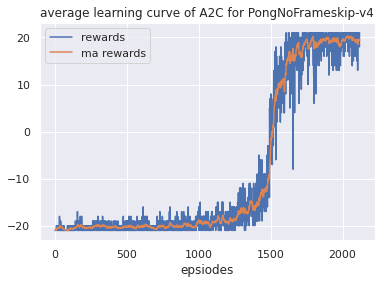

Start Evaluating!
20210719-120604
[20210719-120614: A2C] Episode:1: Frame:2425.0: Reward:21.0
[20210719-120617: A2C] Episode:2: Frame:5410.0: Reward:20.0
[20210719-120618: A2C] Episode:3: Frame:8621.0: Reward:21.0
[20210719-120619: A2C] Episode:4: Frame:12144.0: Reward:19.0
[20210719-120628: A2C] Episode:5: Frame:15352.0: Reward:21.0
[20210719-120629: A2C] Episode:6: Frame:18124.0: Reward:20.0
[20210719-120632: A2C] Episode:7: Frame:21350.0: Reward:20.0
[20210719-120640: A2C] Episode:8: Frame:23779.0: Reward:21.0
[20210719-120641: A2C] Episode:9: Frame:28734.0: Reward:20.0
[20210719-120642: A2C] Episode:10: Frame:31163.0: Reward:21.0
[20210719-120644: A2C] Episode:11: Frame:34953.0: Reward:21.0
[20210719-120652: A2C] Episode:12: Frame:38035.0: Reward:19.0
[20210719-120654: A2C] Episode:13: Frame:41328.0: Reward:21.0
[20210719-120656: A2C] Episode:14: Frame:44683.0: Reward:21.0
[20210719-120657: A2C] Episode:15: Frame:47668.0: Reward:20.0
results saved!


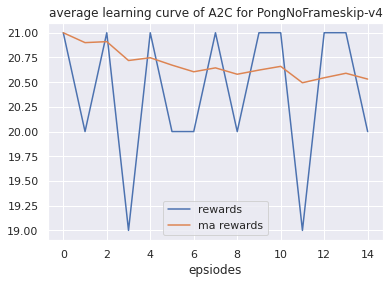

In [15]:
main()

In [11]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 4e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames 
        self.w_critic_loss = 0.5         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0004                 # learning rate
        self.gamma = 0.97              # discount rate of reward
        self.n_multi_step = 45          # number of steps of multi-step style gain 
        self.model = 'Discrete_CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C PongNoFrameskip-v4
Start Training!
20210716-142105
[20210716-142112: A2C] Episode:11: Frame:8332.0: Reward:-21.0: Loss:0.3012
[20210716-142113: A2C] Episode:14: Frame:10687.0: Reward:-21.0: Loss:0.5570
[20210716-142113: A2C] Episode:16: Frame:12321.0: Reward:-21.0: Loss:-0.1040
[20210716-142120: A2C] Episode:18: Frame:13896.0: Reward:-21.0: Loss:-0.0250
[20210716-142120: A2C] Episode:20: Frame:15566.0: Reward:-20.0: Loss:0.1418
[20210716-142121: A2C] Episode:25: Frame:19984.0: Reward:-21.0: Loss:0.1774
[20210716-142121: A2C] Episode:27: Frame:21752.0: Reward:-21.0: Loss:0.2959
[20210716-142121: A2C] Episode:29: Frame:23658.0: Reward:-20.0: Loss:-0.0708
[20210716-142122: A2C] Episode:31: Frame:25616.0: Reward:-20.0: Loss:0.0373
[20210716-142123: A2C] Episode:32: Frame:26713.0: Reward:-20.0: Loss:0.0303
[20210716-142127: A2C] Episode:35: Frame:29275.0: Reward:-20.0: Loss:0.1774
[20210716-142128: A2C] Episode:39: Frame:32518.0: Reward:-20.0: Loss:0.2044
[20210716-142128: A2C] Episode:

[20210716-142341: A2C] Episode:318: Frame:263196.0: Reward:-21.0: Loss:-0.0422
[20210716-142343: A2C] Episode:320: Frame:264717.0: Reward:-21.0: Loss:0.0885
[20210716-142344: A2C] Episode:322: Frame:266236.0: Reward:-21.0: Loss:0.0607
[20210716-142345: A2C] Episode:324: Frame:267750.0: Reward:-21.0: Loss:0.2607
[20210716-142346: A2C] Episode:326: Frame:269268.0: Reward:-21.0: Loss:0.0470
[20210716-142346: A2C] Episode:329: Frame:271540.0: Reward:-21.0: Loss:0.1772
[20210716-142347: A2C] Episode:331: Frame:273058.0: Reward:-21.0: Loss:0.1525
[20210716-142347: A2C] Episode:333: Frame:274569.0: Reward:-21.0: Loss:0.0145
[20210716-142348: A2C] Episode:335: Frame:276082.0: Reward:-21.0: Loss:0.0317
[20210716-142350: A2C] Episode:337: Frame:277599.0: Reward:-21.0: Loss:0.0232
[20210716-142352: A2C] Episode:339: Frame:279114.0: Reward:-21.0: Loss:0.1110
[20210716-142353: A2C] Episode:341: Frame:280634.0: Reward:-21.0: Loss:0.1462
[20210716-142353: A2C] Episode:346: Frame:284427.0: Reward:-21.

[20210716-142538: A2C] Episode:545: Frame:463413.0: Reward:-21.0: Loss:0.1912
[20210716-142539: A2C] Episode:547: Frame:465278.0: Reward:-21.0: Loss:0.1968
[20210716-142540: A2C] Episode:549: Frame:467173.0: Reward:-20.0: Loss:0.1504
[20210716-142542: A2C] Episode:551: Frame:468808.0: Reward:-21.0: Loss:0.0573
[20210716-142543: A2C] Episode:553: Frame:470503.0: Reward:-21.0: Loss:0.1637
[20210716-142544: A2C] Episode:556: Frame:473207.0: Reward:-19.0: Loss:0.0436
[20210716-142545: A2C] Episode:557: Frame:474318.0: Reward:-19.0: Loss:-0.0718
[20210716-142545: A2C] Episode:558: Frame:475430.0: Reward:-19.0: Loss:-0.0217
[20210716-142547: A2C] Episode:560: Frame:477355.0: Reward:-21.0: Loss:0.0860
[20210716-142548: A2C] Episode:562: Frame:479137.0: Reward:-21.0: Loss:0.0427
[20210716-142549: A2C] Episode:563: Frame:480281.0: Reward:-20.0: Loss:0.0998
[20210716-142549: A2C] Episode:565: Frame:482548.0: Reward:-18.0: Loss:0.0776
[20210716-142551: A2C] Episode:567: Frame:484335.0: Reward:-20

[20210716-142740: A2C] Episode:782: Frame:674954.0: Reward:-20.0: Loss:-0.0165
[20210716-142741: A2C] Episode:785: Frame:677441.0: Reward:-20.0: Loss:0.1795
[20210716-142742: A2C] Episode:788: Frame:680186.0: Reward:-20.0: Loss:0.0004
[20210716-142743: A2C] Episode:790: Frame:681902.0: Reward:-21.0: Loss:0.0881
[20210716-142744: A2C] Episode:793: Frame:684281.0: Reward:-21.0: Loss:0.1203
[20210716-142746: A2C] Episode:795: Frame:685797.0: Reward:-21.0: Loss:-0.0134
[20210716-142747: A2C] Episode:797: Frame:687395.0: Reward:-20.0: Loss:0.1210
[20210716-142748: A2C] Episode:799: Frame:688913.0: Reward:-21.0: Loss:0.0523
[20210716-142748: A2C] Episode:801: Frame:690434.0: Reward:-21.0: Loss:0.3246
[20210716-142750: A2C] Episode:803: Frame:692034.0: Reward:-21.0: Loss:0.2361
[20210716-142750: A2C] Episode:805: Frame:693661.0: Reward:-21.0: Loss:-0.0210
[20210716-142751: A2C] Episode:807: Frame:695257.0: Reward:-20.0: Loss:-0.0244
[20210716-142752: A2C] Episode:809: Frame:696851.0: Reward:-

[20210716-142942: A2C] Episode:1029: Frame:886143.0: Reward:-21.0: Loss:0.0873
[20210716-142944: A2C] Episode:1032: Frame:889109.0: Reward:-20.0: Loss:0.0407
[20210716-142945: A2C] Episode:1034: Frame:890770.0: Reward:-21.0: Loss:0.3435
[20210716-142947: A2C] Episode:1037: Frame:893293.0: Reward:-21.0: Loss:-0.1078
[20210716-142947: A2C] Episode:1039: Frame:895039.0: Reward:-21.0: Loss:-0.1148
[20210716-142949: A2C] Episode:1041: Frame:896777.0: Reward:-20.0: Loss:-0.1605
[20210716-142950: A2C] Episode:1043: Frame:898664.0: Reward:-20.0: Loss:0.0473
[20210716-142951: A2C] Episode:1046: Frame:901263.0: Reward:-21.0: Loss:0.3408
[20210716-142953: A2C] Episode:1048: Frame:902997.0: Reward:-20.0: Loss:0.1615
[20210716-142954: A2C] Episode:1051: Frame:905952.0: Reward:-21.0: Loss:-0.0057
[20210716-142954: A2C] Episode:1053: Frame:907631.0: Reward:-21.0: Loss:-0.0315
[20210716-142956: A2C] Episode:1055: Frame:909298.0: Reward:-21.0: Loss:0.0602
[20210716-142957: A2C] Episode:1058: Frame:9118

[20210716-143142: A2C] Episode:1272: Frame:1092547.0: Reward:-21.0: Loss:0.0285
[20210716-143143: A2C] Episode:1274: Frame:1094257.0: Reward:-20.0: Loss:0.0374
[20210716-143144: A2C] Episode:1276: Frame:1095892.0: Reward:-21.0: Loss:0.0693
[20210716-143145: A2C] Episode:1278: Frame:1097403.0: Reward:-21.0: Loss:-0.0217
[20210716-143145: A2C] Episode:1280: Frame:1098996.0: Reward:-20.0: Loss:0.2628
[20210716-143147: A2C] Episode:1282: Frame:1100535.0: Reward:-21.0: Loss:-0.0273
[20210716-143149: A2C] Episode:1286: Frame:1103959.0: Reward:-21.0: Loss:0.0592
[20210716-143150: A2C] Episode:1288: Frame:1105602.0: Reward:-21.0: Loss:0.2313
[20210716-143151: A2C] Episode:1290: Frame:1107354.0: Reward:-21.0: Loss:0.1927
[20210716-143152: A2C] Episode:1292: Frame:1108957.0: Reward:-21.0: Loss:-0.0343
[20210716-143152: A2C] Episode:1294: Frame:1110637.0: Reward:-21.0: Loss:0.0910
[20210716-143153: A2C] Episode:1297: Frame:1113129.0: Reward:-21.0: Loss:0.0809
[20210716-143156: A2C] Episode:1299: 

[20210716-143340: A2C] Episode:1501: Frame:1296062.0: Reward:-20.0: Loss:-0.1365
[20210716-143340: A2C] Episode:1503: Frame:1297743.0: Reward:-21.0: Loss:0.0403
[20210716-143342: A2C] Episode:1505: Frame:1299573.0: Reward:-19.0: Loss:0.1166
[20210716-143343: A2C] Episode:1507: Frame:1301793.0: Reward:-18.0: Loss:-0.0577
[20210716-143345: A2C] Episode:1508: Frame:1302965.0: Reward:-19.0: Loss:0.0770
[20210716-143346: A2C] Episode:1511: Frame:1305619.0: Reward:-20.0: Loss:0.2262
[20210716-143347: A2C] Episode:1514: Frame:1308391.0: Reward:-20.0: Loss:0.0899
[20210716-143347: A2C] Episode:1515: Frame:1309618.0: Reward:-18.0: Loss:-0.0285
[20210716-143349: A2C] Episode:1516: Frame:1310628.0: Reward:-19.0: Loss:-0.0475
[20210716-143349: A2C] Episode:1518: Frame:1312644.0: Reward:-19.0: Loss:0.0284
[20210716-143350: A2C] Episode:1520: Frame:1314463.0: Reward:-21.0: Loss:0.3432
[20210716-143352: A2C] Episode:1522: Frame:1316477.0: Reward:-18.0: Loss:0.0147
[20210716-143353: A2C] Episode:1523:

[20210716-143527: A2C] Episode:1690: Frame:1480528.0: Reward:-18.0: Loss:0.3779
[20210716-143528: A2C] Episode:1691: Frame:1481605.0: Reward:-18.0: Loss:0.0356
[20210716-143529: A2C] Episode:1693: Frame:1483475.0: Reward:-19.0: Loss:-0.0931
[20210716-143530: A2C] Episode:1695: Frame:1485521.0: Reward:-20.0: Loss:-0.2557
[20210716-143531: A2C] Episode:1697: Frame:1487501.0: Reward:-19.0: Loss:-0.0065
[20210716-143532: A2C] Episode:1699: Frame:1489611.0: Reward:-19.0: Loss:0.1927
[20210716-143533: A2C] Episode:1700: Frame:1490693.0: Reward:-20.0: Loss:0.3797
[20210716-143534: A2C] Episode:1701: Frame:1491942.0: Reward:-19.0: Loss:0.1659
[20210716-143534: A2C] Episode:1702: Frame:1492990.0: Reward:-20.0: Loss:-0.2057
[20210716-143535: A2C] Episode:1704: Frame:1495698.0: Reward:-16.0: Loss:-0.0374
[20210716-143537: A2C] Episode:1706: Frame:1497807.0: Reward:-18.0: Loss:-0.0403
[20210716-143537: A2C] Episode:1707: Frame:1498889.0: Reward:-19.0: Loss:-0.0305
[20210716-143539: A2C] Episode:17

[20210716-143711: A2C] Episode:1852: Frame:1659445.0: Reward:-19.0: Loss:0.0313
[20210716-143712: A2C] Episode:1855: Frame:1663110.0: Reward:-18.0: Loss:0.2888
[20210716-143712: A2C] Episode:1856: Frame:1664328.0: Reward:-20.0: Loss:-0.1273
[20210716-143713: A2C] Episode:1857: Frame:1665599.0: Reward:-18.0: Loss:0.0051
[20210716-143714: A2C] Episode:1858: Frame:1667112.0: Reward:-16.0: Loss:0.0375
[20210716-143715: A2C] Episode:1859: Frame:1668279.0: Reward:-20.0: Loss:0.0555
[20210716-143718: A2C] Episode:1860: Frame:1669621.0: Reward:-15.0: Loss:-0.1973
[20210716-143719: A2C] Episode:1861: Frame:1670966.0: Reward:-17.0: Loss:0.0722
[20210716-143720: A2C] Episode:1862: Frame:1672134.0: Reward:-18.0: Loss:-0.1965
[20210716-143720: A2C] Episode:1863: Frame:1673564.0: Reward:-18.0: Loss:0.0403
[20210716-143721: A2C] Episode:1865: Frame:1676274.0: Reward:-18.0: Loss:0.0002
[20210716-143721: A2C] Episode:1866: Frame:1677575.0: Reward:-18.0: Loss:-0.0128
[20210716-143722: A2C] Episode:1867:

[20210716-143858: A2C] Episode:1983: Frame:1847926.0: Reward:-13.0: Loss:-0.0357
[20210716-143859: A2C] Episode:1984: Frame:1849248.0: Reward:-19.0: Loss:0.2172
[20210716-143859: A2C] Episode:1985: Frame:1850576.0: Reward:-18.0: Loss:-0.1187
[20210716-143859: A2C] Episode:1986: Frame:1852064.0: Reward:-18.0: Loss:-0.1427
[20210716-143903: A2C] Episode:1987: Frame:1853803.0: Reward:-13.0: Loss:0.0204
[20210716-143903: A2C] Episode:1988: Frame:1855298.0: Reward:-14.0: Loss:0.0066
[20210716-143904: A2C] Episode:1990: Frame:1858308.0: Reward:-17.0: Loss:0.0737
[20210716-143908: A2C] Episode:1991: Frame:1859818.0: Reward:-17.0: Loss:-0.0485
[20210716-143909: A2C] Episode:1992: Frame:1861754.0: Reward:-13.0: Loss:-0.0334
[20210716-143910: A2C] Episode:1994: Frame:1865300.0: Reward:-12.0: Loss:-0.0909
[20210716-143912: A2C] Episode:1996: Frame:1868227.0: Reward:-17.0: Loss:0.0584
[20210716-143913: A2C] Episode:1997: Frame:1870028.0: Reward:-12.0: Loss:0.0047
[20210716-143914: A2C] Episode:199

[20210716-144059: A2C] Episode:2106: Frame:2059998.0: Reward:-16.0: Loss:0.1112
[20210716-144100: A2C] Episode:2107: Frame:2061904.0: Reward:-13.0: Loss:0.0490
[20210716-144101: A2C] Episode:2108: Frame:2063518.0: Reward:-13.0: Loss:0.1535
[20210716-144102: A2C] Episode:2110: Frame:2066962.0: Reward:-16.0: Loss:0.0051
[20210716-144106: A2C] Episode:2111: Frame:2069317.0: Reward:-5.0: Loss:0.1159
[20210716-144107: A2C] Episode:2112: Frame:2070913.0: Reward:-17.0: Loss:0.0328
[20210716-144108: A2C] Episode:2113: Frame:2073021.0: Reward:-8.0: Loss:0.1708
[20210716-144108: A2C] Episode:2114: Frame:2075374.0: Reward:-6.0: Loss:0.0696
[20210716-144109: A2C] Episode:2115: Frame:2077435.0: Reward:-9.0: Loss:0.1009
[20210716-144111: A2C] Episode:2116: Frame:2078900.0: Reward:-17.0: Loss:0.0882
[20210716-144112: A2C] Episode:2117: Frame:2080395.0: Reward:-18.0: Loss:-0.0199
[20210716-144112: A2C] Episode:2119: Frame:2084256.0: Reward:-7.0: Loss:0.1229
[20210716-144113: A2C] Episode:2120: Frame:2

[20210716-144328: A2C] Episode:2225: Frame:2321619.0: Reward:-3.0: Loss:0.0624
[20210716-144329: A2C] Episode:2226: Frame:2324138.0: Reward:-10.0: Loss:0.1276
[20210716-144330: A2C] Episode:2227: Frame:2326787.0: Reward:-5.0: Loss:-0.0131
[20210716-144333: A2C] Episode:2228: Frame:2328964.0: Reward:-12.0: Loss:0.1046
[20210716-144334: A2C] Episode:2229: Frame:2331786.0: Reward:-4.0: Loss:-0.0522
[20210716-144337: A2C] Episode:2230: Frame:2333885.0: Reward:-12.0: Loss:0.0679
[20210716-144337: A2C] Episode:2231: Frame:2336169.0: Reward:-9.0: Loss:-0.0168
[20210716-144339: A2C] Episode:2232: Frame:2338687.0: Reward:-7.0: Loss:-0.0933
[20210716-144341: A2C] Episode:2233: Frame:2340974.0: Reward:-8.0: Loss:0.0826
[20210716-144341: A2C] Episode:2234: Frame:2343845.0: Reward:3.0: Loss:0.0212
[20210716-144343: A2C] Episode:2235: Frame:2346945.0: Reward:-3.0: Loss:0.0626
[20210716-144343: A2C] Episode:2236: Frame:2349754.0: Reward:5.0: Loss:0.1027
[20210716-144344: A2C] Episode:2237: Frame:2352

[20210716-144615: A2C] Episode:2339: Frame:2623584.0: Reward:11.0: Loss:0.0273
[20210716-144615: A2C] Episode:2341: Frame:2627348.0: Reward:19.0: Loss:0.0280
[20210716-144616: A2C] Episode:2342: Frame:2629831.0: Reward:11.0: Loss:0.0387
[20210716-144617: A2C] Episode:2343: Frame:2633075.0: Reward:5.0: Loss:0.0772
[20210716-144620: A2C] Episode:2344: Frame:2635036.0: Reward:17.0: Loss:-0.0088
[20210716-144622: A2C] Episode:2345: Frame:2637555.0: Reward:9.0: Loss:0.0092
[20210716-144623: A2C] Episode:2347: Frame:2642430.0: Reward:9.0: Loss:-0.0178
[20210716-144627: A2C] Episode:2348: Frame:2644889.0: Reward:11.0: Loss:0.0228
[20210716-144628: A2C] Episode:2349: Frame:2646559.0: Reward:20.0: Loss:0.0126
[20210716-144628: A2C] Episode:2350: Frame:2648419.0: Reward:18.0: Loss:0.0251
[20210716-144629: A2C] Episode:2351: Frame:2650005.0: Reward:21.0: Loss:-0.0011
[20210716-144632: A2C] Episode:2352: Frame:2651949.0: Reward:18.0: Loss:-0.0039
[20210716-144632: A2C] Episode:2353: Frame:2654431.

[20210716-144839: A2C] Episode:2457: Frame:2885480.0: Reward:14.0: Loss:-0.0047
[20210716-144841: A2C] Episode:2458: Frame:2887155.0: Reward:20.0: Loss:0.0134
[20210716-144844: A2C] Episode:2459: Frame:2889060.0: Reward:18.0: Loss:0.0050
[20210716-144845: A2C] Episode:2460: Frame:2891706.0: Reward:13.0: Loss:-0.0153
[20210716-144846: A2C] Episode:2462: Frame:2896202.0: Reward:17.0: Loss:0.0308
[20210716-144847: A2C] Episode:2463: Frame:2898521.0: Reward:16.0: Loss:0.0283
[20210716-144850: A2C] Episode:2464: Frame:2901060.0: Reward:13.0: Loss:0.0162
[20210716-144851: A2C] Episode:2465: Frame:2903352.0: Reward:16.0: Loss:0.0113
[20210716-144852: A2C] Episode:2466: Frame:2905087.0: Reward:19.0: Loss:0.0062
[20210716-144852: A2C] Episode:2467: Frame:2907245.0: Reward:16.0: Loss:0.0025
[20210716-144853: A2C] Episode:2469: Frame:2910707.0: Reward:19.0: Loss:0.0165
[20210716-144855: A2C] Episode:2470: Frame:2912463.0: Reward:19.0: Loss:0.0237
[20210716-144857: A2C] Episode:2471: Frame:2914506

[20210716-145051: A2C] Episode:2579: Frame:3119404.0: Reward:21.0: Loss:0.0053
[20210716-145055: A2C] Episode:2581: Frame:3123269.0: Reward:21.0: Loss:0.0021
[20210716-145056: A2C] Episode:2582: Frame:3124857.0: Reward:21.0: Loss:0.0022
[20210716-145056: A2C] Episode:2584: Frame:3128645.0: Reward:20.0: Loss:0.0082
[20210716-145058: A2C] Episode:2585: Frame:3130316.0: Reward:20.0: Loss:0.0018
[20210716-145100: A2C] Episode:2586: Frame:3131898.0: Reward:21.0: Loss:0.0039
[20210716-145101: A2C] Episode:2587: Frame:3134289.0: Reward:16.0: Loss:0.0042
[20210716-145101: A2C] Episode:2588: Frame:3135966.0: Reward:20.0: Loss:-0.0068
[20210716-145102: A2C] Episode:2589: Frame:3137576.0: Reward:20.0: Loss:0.0050
[20210716-145104: A2C] Episode:2590: Frame:3139522.0: Reward:20.0: Loss:0.0063
[20210716-145105: A2C] Episode:2591: Frame:3141720.0: Reward:18.0: Loss:-0.0000
[20210716-145106: A2C] Episode:2592: Frame:3143390.0: Reward:20.0: Loss:-0.0018
[20210716-145106: A2C] Episode:2593: Frame:314533

[20210716-145310: A2C] Episode:2712: Frame:3360785.0: Reward:21.0: Loss:0.0138
[20210716-145312: A2C] Episode:2715: Frame:3366341.0: Reward:20.0: Loss:-0.0146
[20210716-145313: A2C] Episode:2716: Frame:3368039.0: Reward:20.0: Loss:-0.0028
[20210716-145317: A2C] Episode:2717: Frame:3369628.0: Reward:21.0: Loss:0.0028
[20210716-145318: A2C] Episode:2718: Frame:3371300.0: Reward:20.0: Loss:0.0065
[20210716-145319: A2C] Episode:2719: Frame:3372930.0: Reward:20.0: Loss:0.0022
[20210716-145320: A2C] Episode:2721: Frame:3376753.0: Reward:21.0: Loss:0.0027
[20210716-145321: A2C] Episode:2722: Frame:3378428.0: Reward:20.0: Loss:-0.0085
[20210716-145322: A2C] Episode:2723: Frame:3380359.0: Reward:21.0: Loss:0.0094
[20210716-145323: A2C] Episode:2724: Frame:3381999.0: Reward:20.0: Loss:0.0008
[20210716-145324: A2C] Episode:2725: Frame:3383670.0: Reward:20.0: Loss:0.0046
[20210716-145324: A2C] Episode:2726: Frame:3385309.0: Reward:20.0: Loss:-0.0003
[20210716-145326: A2C] Episode:2727: Frame:33868

[20210716-145528: A2C] Episode:2848: Frame:3606128.0: Reward:21.0: Loss:0.0036
[20210716-145529: A2C] Episode:2849: Frame:3607802.0: Reward:20.0: Loss:0.0026
[20210716-145531: A2C] Episode:2851: Frame:3611621.0: Reward:21.0: Loss:0.0024
[20210716-145532: A2C] Episode:2852: Frame:3613526.0: Reward:21.0: Loss:-0.0056
[20210716-145536: A2C] Episode:2853: Frame:3615172.0: Reward:20.0: Loss:-0.0009
[20210716-145537: A2C] Episode:2854: Frame:3617077.0: Reward:21.0: Loss:-0.0007
[20210716-145538: A2C] Episode:2855: Frame:3619079.0: Reward:20.0: Loss:-0.0033
[20210716-145541: A2C] Episode:2856: Frame:3621014.0: Reward:21.0: Loss:0.0076
[20210716-145541: A2C] Episode:2857: Frame:3622624.0: Reward:20.0: Loss:0.0095
[20210716-145542: A2C] Episode:2858: Frame:3624559.0: Reward:21.0: Loss:-0.0077
[20210716-145543: A2C] Episode:2860: Frame:3628118.0: Reward:20.0: Loss:-0.0092
[20210716-145544: A2C] Episode:2861: Frame:3630008.0: Reward:21.0: Loss:0.0087
[20210716-145545: A2C] Episode:2863: Frame:363

[20210716-145733: A2C] Episode:2969: Frame:3821413.0: Reward:21.0: Loss:-0.0007
[20210716-145734: A2C] Episode:2971: Frame:3824888.0: Reward:21.0: Loss:-0.0035
[20210716-145737: A2C] Episode:2972: Frame:3826560.0: Reward:20.0: Loss:-0.0092
[20210716-145738: A2C] Episode:2975: Frame:3832044.0: Reward:21.0: Loss:-0.0043
[20210716-145738: A2C] Episode:2976: Frame:3833633.0: Reward:21.0: Loss:0.0023
[20210716-145740: A2C] Episode:2977: Frame:3835566.0: Reward:21.0: Loss:-0.0085
[20210716-145742: A2C] Episode:2979: Frame:3839084.0: Reward:21.0: Loss:-0.0040
[20210716-145744: A2C] Episode:2980: Frame:3840976.0: Reward:21.0: Loss:-0.0113
[20210716-145745: A2C] Episode:2981: Frame:3843057.0: Reward:19.0: Loss:-0.0121
[20210716-145746: A2C] Episode:2982: Frame:3844986.0: Reward:21.0: Loss:0.0122
[20210716-145747: A2C] Episode:2983: Frame:3846874.0: Reward:21.0: Loss:0.0030
[20210716-145747: A2C] Episode:2984: Frame:3848808.0: Reward:21.0: Loss:0.0009
[20210716-145748: A2C] Episode:2985: Frame:3

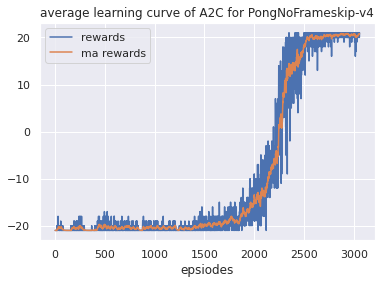

Start Evaluating!
20210716-145912
[20210716-145920: A2C] Episode:1: Frame:1588.0: Reward:21.0
[20210716-145921: A2C] Episode:3: Frame:5358.0: Reward:21.0
[20210716-145921: A2C] Episode:4: Frame:7291.0: Reward:21.0
[20210716-145927: A2C] Episode:5: Frame:8876.0: Reward:21.0
[20210716-145929: A2C] Episode:6: Frame:10461.0: Reward:21.0
[20210716-145929: A2C] Episode:7: Frame:12048.0: Reward:21.0
[20210716-145931: A2C] Episode:8: Frame:13978.0: Reward:21.0
[20210716-145936: A2C] Episode:9: Frame:15566.0: Reward:21.0
[20210716-145936: A2C] Episode:10: Frame:17455.0: Reward:21.0
[20210716-145937: A2C] Episode:11: Frame:19127.0: Reward:20.0
[20210716-145940: A2C] Episode:12: Frame:21016.0: Reward:21.0
[20210716-145944: A2C] Episode:13: Frame:22605.0: Reward:21.0
[20210716-145944: A2C] Episode:14: Frame:24277.0: Reward:20.0
[20210716-145945: A2C] Episode:15: Frame:26210.0: Reward:21.0
[20210716-145948: A2C] Episode:16: Frame:28217.0: Reward:20.0
[20210716-145950: A2C] Episode:17: Frame:29891.0

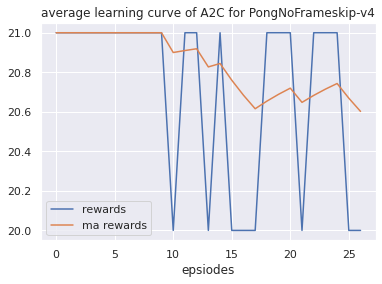

In [12]:
main()

In [ ]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 4e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames 
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.00016                 # learning rate
        self.gamma = 0.98              # discount rate of reward
        self.n_multi_step = 45          # number of steps of multi-step style gain 
        self.model = 'Discrete_CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C PongNoFrameskip-v4
Start Training!
20210803-103733
[20210803-103740: A2C] Episode:15: Frame:11359.0: Reward:-21.0: Loss:0.1102
[20210803-103747: A2C] Episode:31: Frame:23548.0: Reward:-21.0: Loss:-0.0185
[20210803-103754: A2C] Episode:47: Frame:35693.0: Reward:-21.0: Loss:0.0449
[20210803-103801: A2C] Episode:63: Frame:47828.0: Reward:-21.0: Loss:0.0756
[20210803-103808: A2C] Episode:77: Frame:58446.0: Reward:-21.0: Loss:0.2063
[20210803-103809: A2C] Episode:79: Frame:59994.0: Reward:-21.0: Loss:0.5959
[20210803-103814: A2C] Episode:82: Frame:62371.0: Reward:-21.0: Loss:0.1189
[20210803-103815: A2C] Episode:87: Frame:66191.0: Reward:-21.0: Loss:0.0462
[20210803-103815: A2C] Episode:90: Frame:68634.0: Reward:-20.0: Loss:0.4257
[20210803-103816: A2C] Episode:93: Frame:71169.0: Reward:-20.0: Loss:0.4112
[20210803-103817: A2C] Episode:96: Frame:73776.0: Reward:-20.0: Loss:-0.0452
[20210803-103822: A2C] Episode:98: Frame:75321.0: Reward:-21.0: Loss:0.0558
[20210803-103822: A2C] Episode:

[20210803-104011: A2C] Episode:329: Frame:264381.0: Reward:-21.0: Loss:0.0703
[20210803-104011: A2C] Episode:331: Frame:265895.0: Reward:-21.0: Loss:0.0928
[20210803-104012: A2C] Episode:333: Frame:267412.0: Reward:-21.0: Loss:-0.0631
[20210803-104013: A2C] Episode:335: Frame:268925.0: Reward:-21.0: Loss:-0.0343
[20210803-104015: A2C] Episode:337: Frame:270440.0: Reward:-21.0: Loss:0.0275
[20210803-104015: A2C] Episode:339: Frame:271962.0: Reward:-21.0: Loss:0.1374
[20210803-104017: A2C] Episode:341: Frame:273477.0: Reward:-21.0: Loss:-0.0710
[20210803-104018: A2C] Episode:345: Frame:276505.0: Reward:-21.0: Loss:-0.0051
[20210803-104018: A2C] Episode:348: Frame:278785.0: Reward:-21.0: Loss:0.1669
[20210803-104020: A2C] Episode:350: Frame:280308.0: Reward:-21.0: Loss:-0.0344
[20210803-104021: A2C] Episode:352: Frame:281828.0: Reward:-21.0: Loss:0.0856
[20210803-104023: A2C] Episode:355: Frame:284098.0: Reward:-21.0: Loss:-0.1078
[20210803-104025: A2C] Episode:359: Frame:287136.0: Reward

[20210803-104210: A2C] Episode:578: Frame:469787.0: Reward:-20.0: Loss:0.0587
[20210803-104211: A2C] Episode:580: Frame:471428.0: Reward:-20.0: Loss:0.0348
[20210803-104212: A2C] Episode:582: Frame:473066.0: Reward:-20.0: Loss:0.0114
[20210803-104213: A2C] Episode:584: Frame:474751.0: Reward:-21.0: Loss:0.0399
[20210803-104215: A2C] Episode:586: Frame:476371.0: Reward:-20.0: Loss:0.0186
[20210803-104215: A2C] Episode:589: Frame:478700.0: Reward:-21.0: Loss:0.0329
[20210803-104216: A2C] Episode:592: Frame:480969.0: Reward:-21.0: Loss:0.0098
[20210803-104217: A2C] Episode:594: Frame:482482.0: Reward:-21.0: Loss:0.0215
[20210803-104218: A2C] Episode:596: Frame:483997.0: Reward:-21.0: Loss:0.0279
[20210803-104219: A2C] Episode:598: Frame:485514.0: Reward:-21.0: Loss:0.0314
[20210803-104220: A2C] Episode:600: Frame:487033.0: Reward:-21.0: Loss:-0.0134
[20210803-104222: A2C] Episode:602: Frame:488553.0: Reward:-21.0: Loss:0.0244
[20210803-104223: A2C] Episode:605: Frame:490833.0: Reward:-21.

[20210803-104405: A2C] Episode:808: Frame:665306.0: Reward:-19.0: Loss:0.0289
[20210803-104406: A2C] Episode:811: Frame:667997.0: Reward:-21.0: Loss:-0.1145
[20210803-104406: A2C] Episode:813: Frame:670060.0: Reward:-18.0: Loss:0.1899
[20210803-104408: A2C] Episode:815: Frame:672069.0: Reward:-20.0: Loss:-0.0770
[20210803-104409: A2C] Episode:816: Frame:673077.0: Reward:-19.0: Loss:0.1859
[20210803-104410: A2C] Episode:818: Frame:675501.0: Reward:-21.0: Loss:0.0187
[20210803-104410: A2C] Episode:819: Frame:676660.0: Reward:-20.0: Loss:0.4820
[20210803-104411: A2C] Episode:820: Frame:677930.0: Reward:-17.0: Loss:0.0543
[20210803-104412: A2C] Episode:821: Frame:678979.0: Reward:-20.0: Loss:-0.0384
[20210803-104413: A2C] Episode:822: Frame:680139.0: Reward:-18.0: Loss:-0.1570
[20210803-104414: A2C] Episode:826: Frame:683946.0: Reward:-20.0: Loss:0.0700
[20210803-104415: A2C] Episode:828: Frame:686667.0: Reward:-19.0: Loss:-0.0001
[20210803-104416: A2C] Episode:830: Frame:688909.0: Reward:

[20210803-104548: A2C] Episode:991: Frame:853282.0: Reward:-19.0: Loss:-0.1024
[20210803-104551: A2C] Episode:992: Frame:854570.0: Reward:-18.0: Loss:-0.0529
[20210803-104552: A2C] Episode:995: Frame:858226.0: Reward:-20.0: Loss:0.1583
[20210803-104552: A2C] Episode:996: Frame:859280.0: Reward:-19.0: Loss:0.0089
[20210803-104553: A2C] Episode:997: Frame:860357.0: Reward:-20.0: Loss:0.1518
[20210803-104555: A2C] Episode:999: Frame:863051.0: Reward:-17.0: Loss:0.0859
[20210803-104556: A2C] Episode:1000: Frame:864325.0: Reward:-17.0: Loss:0.0255
[20210803-104557: A2C] Episode:1003: Frame:867951.0: Reward:-19.0: Loss:-0.0795
[20210803-104558: A2C] Episode:1005: Frame:870263.0: Reward:-20.0: Loss:-0.0649
[20210803-104601: A2C] Episode:1008: Frame:874034.0: Reward:-17.0: Loss:0.1258
[20210803-104602: A2C] Episode:1010: Frame:876227.0: Reward:-20.0: Loss:-0.0145
[20210803-104604: A2C] Episode:1011: Frame:877439.0: Reward:-18.0: Loss:-0.1151
[20210803-104605: A2C] Episode:1013: Frame:880076.0:

[20210803-104743: A2C] Episode:1122: Frame:1046906.0: Reward:-17.0: Loss:0.0353
[20210803-104743: A2C] Episode:1123: Frame:1048893.0: Reward:-10.0: Loss:0.0426
[20210803-104744: A2C] Episode:1124: Frame:1050732.0: Reward:-14.0: Loss:-0.0075
[20210803-104745: A2C] Episode:1126: Frame:1054726.0: Reward:-10.0: Loss:-0.0122
[20210803-104745: A2C] Episode:1127: Frame:1056429.0: Reward:-15.0: Loss:0.0364
[20210803-104746: A2C] Episode:1128: Frame:1058280.0: Reward:-13.0: Loss:0.0707
[20210803-104747: A2C] Episode:1129: Frame:1059910.0: Reward:-17.0: Loss:0.0444
[20210803-104749: A2C] Episode:1130: Frame:1061489.0: Reward:-17.0: Loss:0.0317
[20210803-104749: A2C] Episode:1131: Frame:1063038.0: Reward:-17.0: Loss:-0.0234
[20210803-104752: A2C] Episode:1132: Frame:1064784.0: Reward:-11.0: Loss:0.1009
[20210803-104753: A2C] Episode:1133: Frame:1066841.0: Reward:-8.0: Loss:0.0578
[20210803-104754: A2C] Episode:1134: Frame:1068583.0: Reward:-13.0: Loss:-0.0755
[20210803-104754: A2C] Episode:1135: 

[20210803-104955: A2C] Episode:1243: Frame:1285297.0: Reward:-11.0: Loss:0.0165
[20210803-104956: A2C] Episode:1244: Frame:1287795.0: Reward:-3.0: Loss:-0.0196
[20210803-104957: A2C] Episode:1245: Frame:1289997.0: Reward:-7.0: Loss:0.0461
[20210803-104959: A2C] Episode:1247: Frame:1294403.0: Reward:-7.0: Loss:0.0232
[20210803-105001: A2C] Episode:1248: Frame:1296463.0: Reward:-10.0: Loss:0.0238
[20210803-105002: A2C] Episode:1249: Frame:1298959.0: Reward:-5.0: Loss:0.1058
[20210803-105004: A2C] Episode:1250: Frame:1301409.0: Reward:-6.0: Loss:0.0673
[20210803-105005: A2C] Episode:1251: Frame:1303670.0: Reward:-10.0: Loss:-0.0477
[20210803-105007: A2C] Episode:1252: Frame:1305957.0: Reward:-8.0: Loss:0.0449
[20210803-105009: A2C] Episode:1253: Frame:1308289.0: Reward:-10.0: Loss:-0.0270
[20210803-105012: A2C] Episode:1254: Frame:1310718.0: Reward:-5.0: Loss:-0.0594
[20210803-105012: A2C] Episode:1255: Frame:1313425.0: Reward:-1.0: Loss:-0.1012
[20210803-105014: A2C] Episode:1258: Frame:

[20210803-105303: A2C] Episode:1359: Frame:1619402.0: Reward:3.0: Loss:0.0061
[20210803-105305: A2C] Episode:1360: Frame:1622652.0: Reward:-2.0: Loss:0.0049
[20210803-105305: A2C] Episode:1361: Frame:1626845.0: Reward:-3.0: Loss:0.0420
[20210803-105312: A2C] Episode:1362: Frame:1630829.0: Reward:-5.0: Loss:-0.0385
[20210803-105313: A2C] Episode:1363: Frame:1634116.0: Reward:4.0: Loss:0.0061
[20210803-105315: A2C] Episode:1364: Frame:1638123.0: Reward:-8.0: Loss:-0.0032
[20210803-105315: A2C] Episode:1365: Frame:1641519.0: Reward:-1.0: Loss:0.0445
[20210803-105318: A2C] Episode:1366: Frame:1645380.0: Reward:-4.0: Loss:-0.0280
[20210803-105320: A2C] Episode:1367: Frame:1648962.0: Reward:6.0: Loss:0.0616
[20210803-105320: A2C] Episode:1368: Frame:1653778.0: Reward:-4.0: Loss:0.0389
[20210803-105325: A2C] Episode:1369: Frame:1657891.0: Reward:-1.0: Loss:0.0466
[20210803-105327: A2C] Episode:1370: Frame:1661358.0: Reward:-8.0: Loss:-0.0088
[20210803-105335: A2C] Episode:1371: Frame:1665269.

[20210803-105710: A2C] Episode:1471: Frame:2091383.0: Reward:1.0: Loss:-0.0345
[20210803-105717: A2C] Episode:1473: Frame:2098534.0: Reward:11.0: Loss:0.0157
[20210803-105719: A2C] Episode:1474: Frame:2101768.0: Reward:13.0: Loss:-0.0253
[20210803-105719: A2C] Episode:1475: Frame:2106322.0: Reward:1.0: Loss:0.0545
[20210803-105725: A2C] Episode:1477: Frame:2113201.0: Reward:14.0: Loss:0.0277
[20210803-105726: A2C] Episode:1478: Frame:2117784.0: Reward:4.0: Loss:-0.0884
[20210803-105731: A2C] Episode:1479: Frame:2123287.0: Reward:4.0: Loss:0.0133
[20210803-105733: A2C] Episode:1480: Frame:2126913.0: Reward:9.0: Loss:0.0218
[20210803-105735: A2C] Episode:1481: Frame:2131327.0: Reward:10.0: Loss:0.0526
[20210803-105741: A2C] Episode:1482: Frame:2135375.0: Reward:11.0: Loss:-0.0205
[20210803-105741: A2C] Episode:1483: Frame:2140768.0: Reward:-1.0: Loss:0.0464
[20210803-105742: A2C] Episode:1484: Frame:2144901.0: Reward:5.0: Loss:0.0138
[20210803-105744: A2C] Episode:1485: Frame:2149728.0: 

[20210803-110104: A2C] Episode:1580: Frame:2523693.0: Reward:16.0: Loss:0.0381
[20210803-110104: A2C] Episode:1581: Frame:2527846.0: Reward:13.0: Loss:-0.0302
[20210803-110107: A2C] Episode:1582: Frame:2531878.0: Reward:13.0: Loss:0.0342
[20210803-110108: A2C] Episode:1584: Frame:2538918.0: Reward:18.0: Loss:0.0036
[20210803-110109: A2C] Episode:1585: Frame:2541795.0: Reward:15.0: Loss:0.0241
[20210803-110110: A2C] Episode:1586: Frame:2544992.0: Reward:16.0: Loss:0.0495
[20210803-110112: A2C] Episode:1587: Frame:2547689.0: Reward:11.0: Loss:-0.0097
[20210803-110113: A2C] Episode:1588: Frame:2551453.0: Reward:15.0: Loss:-0.0075
[20210803-110113: A2C] Episode:1589: Frame:2555545.0: Reward:6.0: Loss:-0.0096
[20210803-110116: A2C] Episode:1590: Frame:2559588.0: Reward:3.0: Loss:0.0220
[20210803-110117: A2C] Episode:1592: Frame:2567013.0: Reward:16.0: Loss:0.0350
[20210803-110122: A2C] Episode:1593: Frame:2570983.0: Reward:13.0: Loss:-0.0375
[20210803-110122: A2C] Episode:1594: Frame:257550

[20210803-110442: A2C] Episode:1696: Frame:2941379.0: Reward:12.0: Loss:0.0197
[20210803-110443: A2C] Episode:1697: Frame:2943576.0: Reward:19.0: Loss:-0.0167
[20210803-110445: A2C] Episode:1699: Frame:2952105.0: Reward:16.0: Loss:-0.0053
[20210803-110447: A2C] Episode:1700: Frame:2955161.0: Reward:13.0: Loss:0.0253
[20210803-110447: A2C] Episode:1701: Frame:2958821.0: Reward:-4.0: Loss:-0.0058
[20210803-110449: A2C] Episode:1702: Frame:2962461.0: Reward:18.0: Loss:0.0223
[20210803-110451: A2C] Episode:1703: Frame:2964916.0: Reward:18.0: Loss:0.0313
[20210803-110453: A2C] Episode:1704: Frame:2967933.0: Reward:15.0: Loss:0.0084
[20210803-110457: A2C] Episode:1705: Frame:2971525.0: Reward:13.0: Loss:0.0267
[20210803-110459: A2C] Episode:1706: Frame:2975757.0: Reward:14.0: Loss:0.0353
[20210803-110507: A2C] Episode:1707: Frame:2980060.0: Reward:11.0: Loss:-0.0198
[20210803-110510: A2C] Episode:1708: Frame:2984229.0: Reward:18.0: Loss:0.0132
[20210803-110514: A2C] Episode:1709: Frame:29879

[20210803-110811: A2C] Episode:1811: Frame:3318991.0: Reward:19.0: Loss:-0.0391
[20210803-110812: A2C] Episode:1812: Frame:3322332.0: Reward:17.0: Loss:0.0084
[20210803-110813: A2C] Episode:1813: Frame:3325488.0: Reward:20.0: Loss:0.0285
[20210803-110816: A2C] Episode:1814: Frame:3328781.0: Reward:20.0: Loss:0.0314
[20210803-110817: A2C] Episode:1815: Frame:3332186.0: Reward:19.0: Loss:0.0035
[20210803-110818: A2C] Episode:1816: Frame:3335387.0: Reward:15.0: Loss:-0.0203
[20210803-110819: A2C] Episode:1817: Frame:3338577.0: Reward:20.0: Loss:0.0081
[20210803-110825: A2C] Episode:1818: Frame:3341742.0: Reward:15.0: Loss:-0.0041
[20210803-110828: A2C] Episode:1819: Frame:3343859.0: Reward:21.0: Loss:-0.0089
[20210803-110830: A2C] Episode:1821: Frame:3350274.0: Reward:20.0: Loss:0.0295
[20210803-110834: A2C] Episode:1822: Frame:3353562.0: Reward:19.0: Loss:-0.0043
[20210803-110836: A2C] Episode:1824: Frame:3360206.0: Reward:19.0: Loss:0.0150
[20210803-110841: A2C] Episode:1826: Frame:3366

[20210803-111120: A2C] Episode:1929: Frame:3668652.0: Reward:19.0: Loss:-0.0174
[20210803-111121: A2C] Episode:1930: Frame:3670771.0: Reward:20.0: Loss:0.0298
[20210803-111121: A2C] Episode:1931: Frame:3673977.0: Reward:21.0: Loss:0.0065
[20210803-111123: A2C] Episode:1932: Frame:3676094.0: Reward:21.0: Loss:0.0087
[20210803-111124: A2C] Episode:1933: Frame:3679299.0: Reward:21.0: Loss:-0.0110
[20210803-111125: A2C] Episode:1934: Frame:3682504.0: Reward:21.0: Loss:0.0102
[20210803-111128: A2C] Episode:1936: Frame:3687950.0: Reward:21.0: Loss:-0.0004
[20210803-111129: A2C] Episode:1937: Frame:3691156.0: Reward:21.0: Loss:-0.0229
[20210803-111131: A2C] Episode:1938: Frame:3693275.0: Reward:21.0: Loss:-0.0179
[20210803-111135: A2C] Episode:1940: Frame:3698477.0: Reward:21.0: Loss:0.0314
[20210803-111135: A2C] Episode:1941: Frame:3700594.0: Reward:21.0: Loss:-0.0025
[20210803-111138: A2C] Episode:1942: Frame:3702711.0: Reward:21.0: Loss:0.0218
[20210803-111140: A2C] Episode:1944: Frame:370

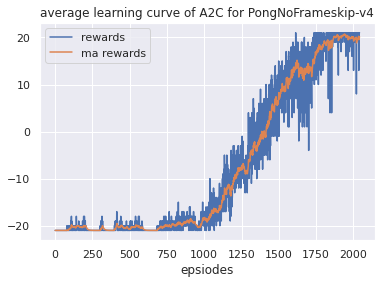

Start Evaluating!
20210803-111418
[20210803-111428: A2C] Episode:1: Frame:1995.0: Reward:21.0
[20210803-111429: A2C] Episode:2: Frame:4036.0: Reward:20.0
[20210803-111429: A2C] Episode:3: Frame:6155.0: Reward:21.0
[20210803-111435: A2C] Episode:4: Frame:9366.0: Reward:21.0
[20210803-111440: A2C] Episode:5: Frame:11482.0: Reward:21.0
[20210803-111445: A2C] Episode:6: Frame:14692.0: Reward:21.0
[20210803-111445: A2C] Episode:7: Frame:17900.0: Reward:21.0
[20210803-111450: A2C] Episode:8: Frame:19899.0: Reward:21.0
[20210803-111451: A2C] Episode:9: Frame:23107.0: Reward:21.0
[20210803-111500: A2C] Episode:10: Frame:25228.0: Reward:21.0
[20210803-111500: A2C] Episode:11: Frame:27227.0: Reward:21.0
[20210803-111501: A2C] Episode:12: Frame:30438.0: Reward:21.0
[20210803-111501: A2C] Episode:13: Frame:33764.0: Reward:20.0
[20210803-111510: A2C] Episode:14: Frame:35762.0: Reward:21.0
[20210803-111511: A2C] Episode:15: Frame:37881.0: Reward:21.0
[20210803-111517: A2C] Episode:16: Frame:41093.0:

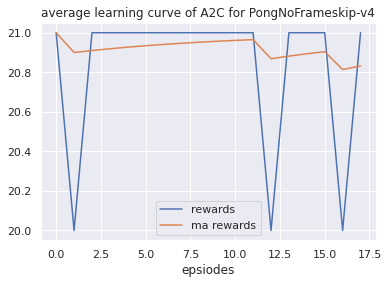

In [44]:
# 0.00016, 0.98, 45, 0.25
main()

## LunarLanderContinuous-v2

In [134]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'LunarLanderContinuous-v2'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 3.5e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.002                 # learning rate
        self.gamma = 0.996              # discount rate of reward
        self.n_multi_step = 1000          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 1.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C LunarLanderContinuous-v2
Start Training!
20210728-180317
[20210728-180321: A2C] Episode:137: Frame:14931.0: Reward:-239.2
[20210728-180326: A2C] Episode:296: Frame:30712.0: Reward:-164.9: Loss:7773.9180
[20210728-180333: A2C] Episode:476: Frame:46952.0: Reward:-94.4: Loss:3161.2888
[20210728-180340: A2C] Episode:672: Frame:63483.0: Reward:-145.0: Loss:1949.8512
[20210728-180345: A2C] Episode:881: Frame:79419.0: Reward:-144.5: Loss:2219.5278
[20210728-180350: A2C] Episode:1090: Frame:95378.0: Reward:-195.8: Loss:2096.2830
[20210728-180355: A2C] Episode:1301: Frame:111376.0: Reward:-140.7: Loss:1953.7139
[20210728-180400: A2C] Episode:1524: Frame:127455.0: Reward:-104.6: Loss:2152.8110
[20210728-180405: A2C] Episode:1737: Frame:143262.0: Reward:-116.3: Loss:2090.2720
[20210728-180409: A2C] Episode:1956: Frame:159270.0: Reward:-145.0: Loss:2013.3362
[20210728-180414: A2C] Episode:2178: Frame:175118.0: Reward:-120.3: Loss:1838.3583
[20210728-180419: A2C] Episode:2401: Frame:191411.0: R

[20210728-181524: A2C] Episode:10158: Frame:1607901.0: Reward:-49.1: Loss:312.6951
[20210728-181531: A2C] Episode:10187: Frame:1624645.0: Reward:201.6: Loss:378.0702
[20210728-181540: A2C] Episode:10212: Frame:1640112.0: Reward:-0.1: Loss:413.3812
[20210728-181547: A2C] Episode:10244: Frame:1658916.0: Reward:-25.4: Loss:411.2072
[20210728-181555: A2C] Episode:10271: Frame:1674492.0: Reward:-14.6: Loss:444.2411
[20210728-181602: A2C] Episode:10292: Frame:1689347.0: Reward:127.4: Loss:407.1553
[20210728-181610: A2C] Episode:10318: Frame:1705279.0: Reward:98.7: Loss:270.0193
[20210728-181617: A2C] Episode:10341: Frame:1721365.0: Reward:109.9: Loss:334.4112
[20210728-181625: A2C] Episode:10362: Frame:1737539.0: Reward:133.4: Loss:389.6720
[20210728-181634: A2C] Episode:10383: Frame:1753024.0: Reward:102.9: Loss:374.9700
[20210728-181641: A2C] Episode:10402: Frame:1766852.0: Reward:197.6: Loss:348.8661
[20210728-181648: A2C] Episode:10424: Frame:1784362.0: Reward:28.6: Loss:402.7202
[202107

[20210728-182658: A2C] Episode:13515: Frame:3194631.0: Reward:52.3: Loss:676.3033
[20210728-182705: A2C] Episode:13547: Frame:3210775.0: Reward:138.3: Loss:525.1288
[20210728-182712: A2C] Episode:13587: Frame:3226892.0: Reward:2.8: Loss:515.2688
[20210728-182719: A2C] Episode:13621: Frame:3241759.0: Reward:152.9: Loss:1139.1704
[20210728-182725: A2C] Episode:13646: Frame:3256647.0: Reward:11.2: Loss:924.3429
[20210728-182732: A2C] Episode:13682: Frame:3274028.0: Reward:-31.4: Loss:703.1046
[20210728-182739: A2C] Episode:13713: Frame:3291721.0: Reward:-115.7: Loss:963.8340
[20210728-182745: A2C] Episode:13751: Frame:3306797.0: Reward:278.8: Loss:1010.2575
[20210728-182752: A2C] Episode:13784: Frame:3323650.0: Reward:210.0: Loss:1088.0620
[20210728-182800: A2C] Episode:13816: Frame:3338432.0: Reward:132.9: Loss:996.9717
[20210728-182806: A2C] Episode:13846: Frame:3353970.0: Reward:240.5: Loss:793.3761
[20210728-182812: A2C] Episode:13873: Frame:3371694.0: Reward:267.9: Loss:833.3317
[202

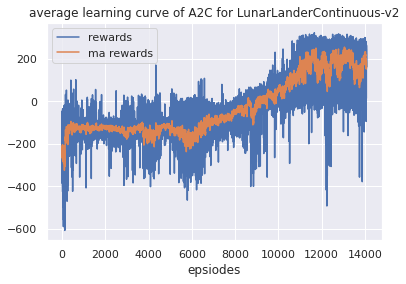

Start Evaluating!
20210728-182908
[20210728-182910: A2C] Episode:1: Frame:449.0: Reward:271.8
[20210728-182911: A2C] Episode:2: Frame:1066.0: Reward:281.6
[20210728-182912: A2C] Episode:3: Frame:1926.0: Reward:217.9
[20210728-182913: A2C] Episode:4: Frame:2898.0: Reward:224.6
[20210728-182914: A2C] Episode:5: Frame:3537.0: Reward:185.1
[20210728-182916: A2C] Episode:6: Frame:3894.0: Reward:288.0
[20210728-182916: A2C] Episode:7: Frame:4551.0: Reward:157.4
[20210728-182916: A2C] Episode:8: Frame:5551.0: Reward:147.9
[20210728-182918: A2C] Episode:9: Frame:5964.0: Reward:252.2
[20210728-182918: A2C] Episode:10: Frame:6277.0: Reward:285.8
[20210728-182918: A2C] Episode:11: Frame:7277.0: Reward:90.0
[20210728-182920: A2C] Episode:12: Frame:8102.0: Reward:241.4
[20210728-182920: A2C] Episode:13: Frame:8521.0: Reward:252.9
[20210728-182921: A2C] Episode:14: Frame:9105.0: Reward:160.0
[20210728-182923: A2C] Episode:15: Frame:10105.0: Reward:89.6
[20210728-182923: A2C] Episode:16: Frame:10658.

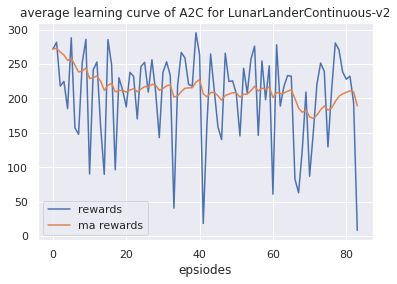

In [8]:
# 0.002, 0.996, 1000
main()

## Pendulum-v0

In [7]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'Pendulum-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.5e6     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.90              # discount rate of reward
        self.n_multi_step = 16          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 2.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C Pendulum-v0
Start Training!
20210727-100033
[20210727-100035: A2C] Episode:16: Frame:3200.0: Reward:-1821.8: Loss:114.6363
[20210727-100037: A2C] Episode:32: Frame:6400.0: Reward:-1399.4: Loss:522.4687
[20210727-100038: A2C] Episode:48: Frame:9600.0: Reward:-1301.5: Loss:150.3556
[20210727-100040: A2C] Episode:64: Frame:12800.0: Reward:-1560.9: Loss:543.0312
[20210727-100042: A2C] Episode:80: Frame:16000.0: Reward:-1632.9: Loss:132.5549
[20210727-100043: A2C] Episode:96: Frame:19200.0: Reward:-1664.7: Loss:445.4542
[20210727-100045: A2C] Episode:112: Frame:22400.0: Reward:-1665.6: Loss:124.5368
[20210727-100047: A2C] Episode:128: Frame:25600.0: Reward:-1557.9: Loss:215.0400
[20210727-100049: A2C] Episode:144: Frame:28800.0: Reward:-1719.4: Loss:65.3622
[20210727-100050: A2C] Episode:160: Frame:32000.0: Reward:-1517.3: Loss:298.3800
[20210727-100052: A2C] Episode:176: Frame:35200.0: Reward:-1730.3: Loss:84.6515
[20210727-100053: A2C] Episode:192: Frame:38400.0: Reward:-1737.7: Loss:

[20210727-100309: A2C] Episode:1616: Frame:323200.0: Reward:-1115.3: Loss:183.6831
[20210727-100311: A2C] Episode:1632: Frame:326400.0: Reward:-1083.2: Loss:211.1161
[20210727-100312: A2C] Episode:1648: Frame:329600.0: Reward:-881.4: Loss:141.5670
[20210727-100313: A2C] Episode:1664: Frame:332800.0: Reward:-1052.0: Loss:201.3235
[20210727-100315: A2C] Episode:1680: Frame:336000.0: Reward:-1408.1: Loss:239.5239
[20210727-100316: A2C] Episode:1696: Frame:339200.0: Reward:-1243.0: Loss:282.7194
[20210727-100318: A2C] Episode:1712: Frame:342400.0: Reward:-1392.2: Loss:201.9965
[20210727-100319: A2C] Episode:1728: Frame:345600.0: Reward:-1271.7: Loss:235.8873
[20210727-100321: A2C] Episode:1744: Frame:348800.0: Reward:-1250.9: Loss:166.5483
[20210727-100322: A2C] Episode:1760: Frame:352000.0: Reward:-1079.2: Loss:183.1702
[20210727-100324: A2C] Episode:1776: Frame:355200.0: Reward:-773.4: Loss:122.8421
[20210727-100325: A2C] Episode:1792: Frame:358400.0: Reward:-1104.7: Loss:192.4794
[20210

[20210727-100541: A2C] Episode:3232: Frame:646400.0: Reward:-808.6: Loss:51.4065
[20210727-100543: A2C] Episode:3248: Frame:649600.0: Reward:-260.6: Loss:16.5260
[20210727-100544: A2C] Episode:3264: Frame:652800.0: Reward:-512.6: Loss:16.4794
[20210727-100546: A2C] Episode:3280: Frame:656000.0: Reward:-520.9: Loss:28.1625
[20210727-100547: A2C] Episode:3296: Frame:659200.0: Reward:-679.6: Loss:9.0882
[20210727-100549: A2C] Episode:3312: Frame:662400.0: Reward:-129.4: Loss:46.2941
[20210727-100550: A2C] Episode:3328: Frame:665600.0: Reward:-130.6: Loss:8.1968
[20210727-100552: A2C] Episode:3344: Frame:668800.0: Reward:-259.8: Loss:15.2340
[20210727-100553: A2C] Episode:3360: Frame:672000.0: Reward:-921.8: Loss:11.6696
[20210727-100555: A2C] Episode:3376: Frame:675200.0: Reward:-2.4: Loss:9.5879
[20210727-100556: A2C] Episode:3392: Frame:678400.0: Reward:-523.2: Loss:22.6771
[20210727-100558: A2C] Episode:3408: Frame:681600.0: Reward:-713.0: Loss:32.8546
[20210727-100559: A2C] Episode:34

[20210727-100811: A2C] Episode:4880: Frame:976000.0: Reward:-2.7: Loss:3.5440
[20210727-100812: A2C] Episode:4896: Frame:979200.0: Reward:-250.2: Loss:1.8712
[20210727-100814: A2C] Episode:4912: Frame:982400.0: Reward:-409.7: Loss:3.3455
[20210727-100815: A2C] Episode:4928: Frame:985600.0: Reward:-516.4: Loss:0.4098
[20210727-100817: A2C] Episode:4944: Frame:988800.0: Reward:-129.5: Loss:1.9922
[20210727-100818: A2C] Episode:4960: Frame:992000.0: Reward:-518.0: Loss:0.2935
[20210727-100820: A2C] Episode:4976: Frame:995200.0: Reward:-255.6: Loss:11.3108
[20210727-100821: A2C] Episode:4992: Frame:998400.0: Reward:-513.7: Loss:2.3289
[20210727-100822: A2C] Episode:5008: Frame:1001600.0: Reward:-262.5: Loss:7.5003
[20210727-100824: A2C] Episode:5024: Frame:1004800.0: Reward:-388.3: Loss:-0.1241
[20210727-100825: A2C] Episode:5040: Frame:1008000.0: Reward:-257.1: Loss:4.5013
[20210727-100827: A2C] Episode:5056: Frame:1011200.0: Reward:-568.5: Loss:0.5626
[20210727-100828: A2C] Episode:5072:

[20210727-101050: A2C] Episode:6512: Frame:1302400.0: Reward:-402.7: Loss:1.6818
[20210727-101051: A2C] Episode:6528: Frame:1305600.0: Reward:-129.0: Loss:0.0397
[20210727-101053: A2C] Episode:6544: Frame:1308800.0: Reward:-1202.3: Loss:1.6947
[20210727-101054: A2C] Episode:6560: Frame:1312000.0: Reward:-405.5: Loss:0.9896
[20210727-101056: A2C] Episode:6576: Frame:1315200.0: Reward:-1.7: Loss:1.6882
[20210727-101057: A2C] Episode:6592: Frame:1318400.0: Reward:-127.5: Loss:0.3719
[20210727-101059: A2C] Episode:6608: Frame:1321600.0: Reward:-257.3: Loss:2.0265
[20210727-101100: A2C] Episode:6624: Frame:1324800.0: Reward:-2.5: Loss:1.1099
[20210727-101102: A2C] Episode:6640: Frame:1328000.0: Reward:-381.4: Loss:13.8873
[20210727-101103: A2C] Episode:6656: Frame:1331200.0: Reward:-506.6: Loss:0.1231
[20210727-101105: A2C] Episode:6672: Frame:1334400.0: Reward:-374.3: Loss:1.4851
[20210727-101106: A2C] Episode:6688: Frame:1337600.0: Reward:-3.0: Loss:0.3541
[20210727-101108: A2C] Episode:6

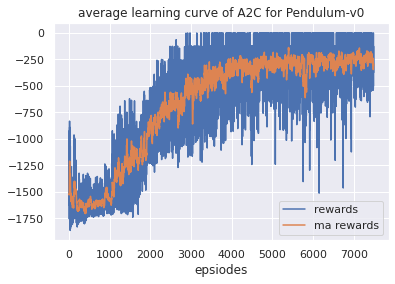

Start Evaluating!
20210727-101217
[20210727-101217: A2C] Episode:4: Frame:800.0: Reward:-253.1
[20210727-101218: A2C] Episode:8: Frame:1600.0: Reward:-127.1
[20210727-101218: A2C] Episode:12: Frame:2400.0: Reward:-126.4
[20210727-101219: A2C] Episode:16: Frame:3200.0: Reward:-256.0
[20210727-101219: A2C] Episode:20: Frame:4000.0: Reward:-132.4
[20210727-101220: A2C] Episode:24: Frame:4800.0: Reward:-254.1
[20210727-101220: A2C] Episode:28: Frame:5600.0: Reward:-369.9
[20210727-101221: A2C] Episode:32: Frame:6400.0: Reward:-1.9
[20210727-101222: A2C] Episode:36: Frame:7200.0: Reward:-132.5
[20210727-101222: A2C] Episode:40: Frame:8000.0: Reward:-1.7
[20210727-101223: A2C] Episode:44: Frame:8800.0: Reward:-127.6
[20210727-101223: A2C] Episode:48: Frame:9600.0: Reward:-420.1
results saved!


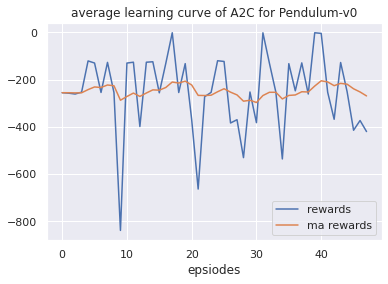

In [9]:
# 0.0002,16,0.25
main()

In [50]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'Pendulum-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 7e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0016                 # learning rate
        self.gamma = 0.90              # discount rate of reward
        self.n_multi_step = 15          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C Pendulum-v0
Start Training!
20210723-112327
[20210723-112328: A2C] Episode:16: Frame:3200.0: Reward:-1476.5: Loss:96.6385
[20210723-112329: A2C] Episode:32: Frame:6400.0: Reward:-1344.4: Loss:197.1214
[20210723-112331: A2C] Episode:48: Frame:9600.0: Reward:-1286.8: Loss:503.8225
[20210723-112332: A2C] Episode:64: Frame:12800.0: Reward:-1460.8: Loss:110.7413
[20210723-112333: A2C] Episode:80: Frame:16000.0: Reward:-1585.3: Loss:150.9267
[20210723-112334: A2C] Episode:96: Frame:19200.0: Reward:-1631.6: Loss:279.1816
[20210723-112336: A2C] Episode:112: Frame:22400.0: Reward:-1565.7: Loss:115.7228
[20210723-112337: A2C] Episode:128: Frame:25600.0: Reward:-1556.1: Loss:54.9614
[20210723-112339: A2C] Episode:144: Frame:28800.0: Reward:-1585.4: Loss:132.1006
[20210723-112340: A2C] Episode:160: Frame:32000.0: Reward:-1468.1: Loss:101.4574
[20210723-112341: A2C] Episode:176: Frame:35200.0: Reward:-1551.4: Loss:71.1575
[20210723-112342: A2C] Episode:192: Frame:38400.0: Reward:-1453.1: Loss:1

[20210723-112527: A2C] Episode:1632: Frame:326400.0: Reward:-141.0: Loss:100.4068
[20210723-112528: A2C] Episode:1648: Frame:329600.0: Reward:-795.6: Loss:106.0645
[20210723-112529: A2C] Episode:1664: Frame:332800.0: Reward:-1115.0: Loss:101.8960
[20210723-112530: A2C] Episode:1680: Frame:336000.0: Reward:-1323.0: Loss:101.2993
[20210723-112531: A2C] Episode:1696: Frame:339200.0: Reward:-964.0: Loss:69.3349
[20210723-112532: A2C] Episode:1712: Frame:342400.0: Reward:-1056.2: Loss:85.4473
[20210723-112533: A2C] Episode:1728: Frame:345600.0: Reward:-837.1: Loss:22.9452
[20210723-112534: A2C] Episode:1744: Frame:348800.0: Reward:-559.4: Loss:1.5462
[20210723-112536: A2C] Episode:1760: Frame:352000.0: Reward:-133.7: Loss:30.1897
[20210723-112537: A2C] Episode:1776: Frame:355200.0: Reward:-136.2: Loss:5.7030
[20210723-112538: A2C] Episode:1792: Frame:358400.0: Reward:-139.0: Loss:27.0701
[20210723-112539: A2C] Episode:1808: Frame:361600.0: Reward:-668.3: Loss:7.9331
[20210723-112540: A2C] E

[20210723-112735: A2C] Episode:3280: Frame:656000.0: Reward:-405.3: Loss:1.1472
[20210723-112736: A2C] Episode:3296: Frame:659200.0: Reward:-654.2: Loss:0.7799
[20210723-112737: A2C] Episode:3312: Frame:662400.0: Reward:-132.4: Loss:0.1125
[20210723-112738: A2C] Episode:3328: Frame:665600.0: Reward:-134.2: Loss:0.2725
[20210723-112739: A2C] Episode:3344: Frame:668800.0: Reward:-134.1: Loss:0.9968
[20210723-112739: A2C] Episode:3360: Frame:672000.0: Reward:-272.9: Loss:-0.0973
[20210723-112740: A2C] Episode:3376: Frame:675200.0: Reward:-1.5: Loss:1.2630
[20210723-112741: A2C] Episode:3392: Frame:678400.0: Reward:-275.8: Loss:0.7122
[20210723-112741: A2C] Episode:3408: Frame:681600.0: Reward:-581.9: Loss:0.1033
[20210723-112742: A2C] Episode:3424: Frame:684800.0: Reward:-441.3: Loss:1.0920
[20210723-112743: A2C] Episode:3440: Frame:688000.0: Reward:-591.8: Loss:0.6175
[20210723-112744: A2C] Episode:3456: Frame:691200.0: Reward:-139.4: Loss:0.0842
[20210723-112744: A2C] Episode:3472: Fram

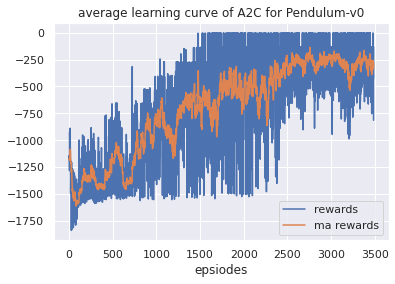

Start Evaluating!
20210723-112746
[20210723-112747: A2C] Episode:4: Frame:800.0: Reward:-267.1
[20210723-112747: A2C] Episode:8: Frame:1600.0: Reward:-134.2
[20210723-112747: A2C] Episode:12: Frame:2400.0: Reward:-134.8
[20210723-112748: A2C] Episode:16: Frame:3200.0: Reward:-269.2
[20210723-112748: A2C] Episode:20: Frame:4000.0: Reward:-418.4
[20210723-112749: A2C] Episode:24: Frame:4800.0: Reward:-136.4
[20210723-112749: A2C] Episode:28: Frame:5600.0: Reward:-422.2
[20210723-112750: A2C] Episode:32: Frame:6400.0: Reward:-1.4
[20210723-112750: A2C] Episode:36: Frame:7200.0: Reward:-137.7
[20210723-112750: A2C] Episode:40: Frame:8000.0: Reward:-1.0
[20210723-112751: A2C] Episode:44: Frame:8800.0: Reward:-130.9
[20210723-112751: A2C] Episode:48: Frame:9600.0: Reward:-560.2
results saved!


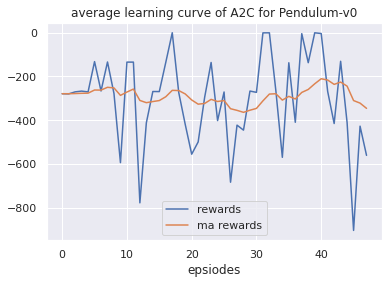

In [51]:
#0.90,0.0016,15,0.25
main()

## CartPole-v0

In [7]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'CartPole-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.batch_size = 128*4          # number of examples in one batch
        self.w_critic_loss = 0.5         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.001                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.n_multi_step = 2          # number of steps of multi-step style gain 
        self.epsilon_start = 0.050      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.0001        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'Discrete_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C CartPole-v0
Start Training!
20210713-101850
[20210713-101850: A2C] Episode:2: Frame:23.0: Reward:12.0: Loss:2.1352
[20210713-101850: A2C] Episode:73: Frame:1030.0: Reward:14.0: Loss:7.6507
[20210713-101851: A2C] Episode:163: Frame:2061.0: Reward:12.0: Loss:8.5179
[20210713-101851: A2C] Episode:270: Frame:3080.0: Reward:9.0: Loss:0.4538
[20210713-101851: A2C] Episode:359: Frame:4084.0: Reward:10.0: Loss:5.2823
[20210713-101852: A2C] Episode:421: Frame:5096.0: Reward:30.0: Loss:2.8505
[20210713-101852: A2C] Episode:468: Frame:6118.0: Reward:30.0: Loss:13.4189
[20210713-101853: A2C] Episode:498: Frame:7140.0: Reward:49.0: Loss:45.5552
[20210713-101853: A2C] Episode:516: Frame:8162.0: Reward:26.0: Loss:23.7820
[20210713-101854: A2C] Episode:534: Frame:9206.0: Reward:72.0: Loss:40.3700
[20210713-101854: A2C] Episode:549: Frame:10237.0: Reward:51.0: Loss:16.3721
[20210713-101854: A2C] Episode:569: Frame:11286.0: Reward:68.0: Loss:2.8087
[20210713-101855: A2C] Episode:585: Frame:12441.0: 

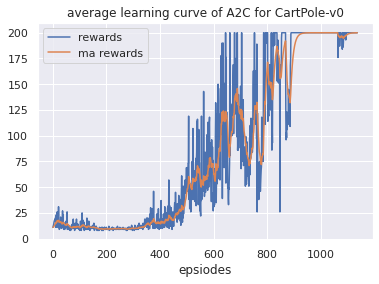

Start Evaluating!
20210713-101938
[20210713-101938: A2C] Episode:4: Frame:800.0: Reward:200.0
[20210713-101939: A2C] Episode:8: Frame:1600.0: Reward:200.0
[20210713-101939: A2C] Episode:12: Frame:2400.0: Reward:200.0
[20210713-101939: A2C] Episode:16: Frame:3200.0: Reward:200.0
[20210713-101939: A2C] Episode:20: Frame:4000.0: Reward:200.0
[20210713-101940: A2C] Episode:24: Frame:4800.0: Reward:200.0
[20210713-101940: A2C] Episode:28: Frame:5600.0: Reward:200.0
[20210713-101940: A2C] Episode:32: Frame:6400.0: Reward:200.0
[20210713-101941: A2C] Episode:36: Frame:7200.0: Reward:200.0
[20210713-101941: A2C] Episode:40: Frame:8000.0: Reward:200.0
[20210713-101941: A2C] Episode:44: Frame:8800.0: Reward:200.0
[20210713-101941: A2C] Episode:48: Frame:9600.0: Reward:200.0
results saved!


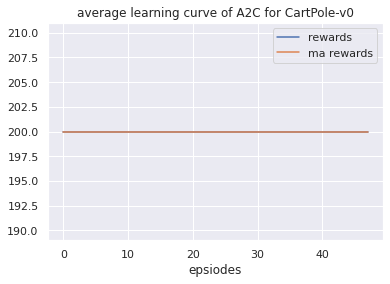

In [19]:
main()

In [80]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'A2C'             # name of agent
        self.env_id = 'CartPole-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 5e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.97              # discount rate of reward
        self.n_multi_step = 6          # number of steps of multi-step style gain 
        self.model = 'Discrete_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

A2C CartPole-v0
Start Training!
20210722-181709
[20210722-181709: A2C] Episode:5: Frame:53.0: Reward:12.0: Loss:5.1050
[20210722-181710: A2C] Episode:63: Frame:1142.0: Reward:31.0: Loss:4.9315
[20210722-181711: A2C] Episode:125: Frame:2281.0: Reward:11.0: Loss:3.2430
[20210722-181711: A2C] Episode:188: Frame:3313.0: Reward:17.0: Loss:3.8636
[20210722-181712: A2C] Episode:249: Frame:4358.0: Reward:10.0: Loss:4.5675
[20210722-181712: A2C] Episode:318: Frame:5429.0: Reward:21.0: Loss:4.4623
[20210722-181713: A2C] Episode:380: Frame:6481.0: Reward:62.0: Loss:4.7704
[20210722-181713: A2C] Episode:442: Frame:7511.0: Reward:35.0: Loss:4.4675
[20210722-181714: A2C] Episode:511: Frame:8639.0: Reward:29.0: Loss:3.3047
[20210722-181715: A2C] Episode:562: Frame:9668.0: Reward:17.0: Loss:5.2035
[20210722-181715: A2C] Episode:614: Frame:10739.0: Reward:18.0: Loss:5.2328
[20210722-181716: A2C] Episode:671: Frame:11813.0: Reward:23.0: Loss:4.5386
[20210722-181716: A2C] Episode:720: Frame:12829.0: Rewa

[20210722-181758: A2C] Episode:2920: Frame:115513.0: Reward:131.0: Loss:4.7860
[20210722-181758: A2C] Episode:2939: Frame:116689.0: Reward:108.0: Loss:2.8828
[20210722-181759: A2C] Episode:2950: Frame:117950.0: Reward:153.0: Loss:4.0455
[20210722-181759: A2C] Episode:2960: Frame:119209.0: Reward:19.0: Loss:19.1922
[20210722-181800: A2C] Episode:2976: Frame:120246.0: Reward:22.0: Loss:5.1497
[20210722-181800: A2C] Episode:2992: Frame:121280.0: Reward:17.0: Loss:12.6111
[20210722-181800: A2C] Episode:3025: Frame:122297.0: Reward:21.0: Loss:5.4120
[20210722-181801: A2C] Episode:3048: Frame:123311.0: Reward:17.0: Loss:3.8536
[20210722-181801: A2C] Episode:3061: Frame:124426.0: Reward:171.0: Loss:2.6259
[20210722-181801: A2C] Episode:3073: Frame:125765.0: Reward:193.0: Loss:2.3017
[20210722-181802: A2C] Episode:3085: Frame:126818.0: Reward:123.0: Loss:4.8735
[20210722-181802: A2C] Episode:3094: Frame:127934.0: Reward:141.0: Loss:4.1176
[20210722-181802: A2C] Episode:3103: Frame:129032.0: Re

[20210722-181828: A2C] Episode:3719: Frame:232445.0: Reward:200.0: Loss:9.4397
[20210722-181828: A2C] Episode:3728: Frame:233674.0: Reward:200.0: Loss:17.5317
[20210722-181828: A2C] Episode:3733: Frame:234674.0: Reward:200.0: Loss:9.6268
[20210722-181829: A2C] Episode:3740: Frame:235804.0: Reward:121.0: Loss:4.1323
[20210722-181829: A2C] Episode:3747: Frame:236870.0: Reward:83.0: Loss:13.8130
[20210722-181829: A2C] Episode:3756: Frame:238130.0: Reward:200.0: Loss:9.5009
[20210722-181830: A2C] Episode:3764: Frame:239358.0: Reward:157.0: Loss:7.0358
[20210722-181830: A2C] Episode:3770: Frame:240447.0: Reward:200.0: Loss:1.3834
[20210722-181830: A2C] Episode:3776: Frame:241516.0: Reward:197.0: Loss:1.2869
[20210722-181831: A2C] Episode:3784: Frame:242718.0: Reward:200.0: Loss:8.9946
[20210722-181831: A2C] Episode:3792: Frame:243801.0: Reward:140.0: Loss:5.9824
[20210722-181831: A2C] Episode:3799: Frame:244905.0: Reward:197.0: Loss:3.1936
[20210722-181831: A2C] Episode:3806: Frame:246036.0

[20210722-181858: A2C] Episode:4519: Frame:348223.0: Reward:105.0: Loss:0.3275
[20210722-181859: A2C] Episode:4528: Frame:349228.0: Reward:114.0: Loss:0.5531
[20210722-181859: A2C] Episode:4537: Frame:350365.0: Reward:143.0: Loss:0.2845
[20210722-181859: A2C] Episode:4546: Frame:351425.0: Reward:107.0: Loss:-0.0548
[20210722-181900: A2C] Episode:4555: Frame:352489.0: Reward:115.0: Loss:0.4077
[20210722-181900: A2C] Episode:4563: Frame:353565.0: Reward:123.0: Loss:0.2786
[20210722-181900: A2C] Episode:4572: Frame:354832.0: Reward:153.0: Loss:0.4676
[20210722-181901: A2C] Episode:4580: Frame:355959.0: Reward:138.0: Loss:0.3135
[20210722-181901: A2C] Episode:4587: Frame:357068.0: Reward:176.0: Loss:0.1583
[20210722-181901: A2C] Episode:4595: Frame:358305.0: Reward:142.0: Loss:0.1261
[20210722-181902: A2C] Episode:4603: Frame:359356.0: Reward:134.0: Loss:0.0938
[20210722-181902: A2C] Episode:4611: Frame:360488.0: Reward:146.0: Loss:0.0804
[20210722-181902: A2C] Episode:4619: Frame:361502.0

[20210722-181936: A2C] Episode:5290: Frame:466780.0: Reward:124.0: Loss:0.1275
[20210722-181936: A2C] Episode:5299: Frame:467900.0: Reward:130.0: Loss:2.0553
[20210722-181937: A2C] Episode:5307: Frame:468937.0: Reward:141.0: Loss:0.0990
[20210722-181937: A2C] Episode:5315: Frame:470052.0: Reward:153.0: Loss:0.0733
[20210722-181937: A2C] Episode:5322: Frame:471086.0: Reward:167.0: Loss:0.0777
[20210722-181937: A2C] Episode:5329: Frame:472151.0: Reward:176.0: Loss:0.0877
[20210722-181938: A2C] Episode:5336: Frame:473294.0: Reward:180.0: Loss:0.1479
[20210722-181938: A2C] Episode:5343: Frame:474396.0: Reward:168.0: Loss:0.1333
[20210722-181938: A2C] Episode:5350: Frame:475600.0: Reward:150.0: Loss:0.0666
[20210722-181939: A2C] Episode:5356: Frame:476706.0: Reward:190.0: Loss:0.1332
[20210722-181939: A2C] Episode:5362: Frame:477859.0: Reward:175.0: Loss:0.0567
[20210722-181939: A2C] Episode:5367: Frame:478859.0: Reward:200.0: Loss:6.1841
[20210722-181940: A2C] Episode:5373: Frame:480039.0:

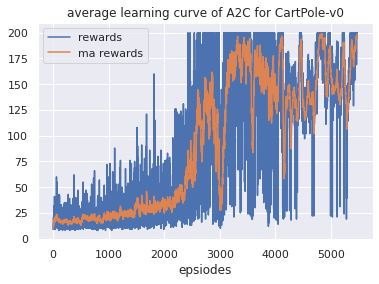

Start Evaluating!
20210722-181946
[20210722-181946: A2C] Episode:4: Frame:800.0: Reward:200.0
[20210722-181947: A2C] Episode:8: Frame:1600.0: Reward:200.0
[20210722-181947: A2C] Episode:12: Frame:2400.0: Reward:200.0
[20210722-181948: A2C] Episode:16: Frame:3200.0: Reward:200.0
[20210722-181948: A2C] Episode:20: Frame:4000.0: Reward:200.0
[20210722-181949: A2C] Episode:21: Frame:4195.0: Reward:195.0
[20210722-181949: A2C] Episode:24: Frame:4795.0: Reward:200.0
[20210722-181949: A2C] Episode:25: Frame:4995.0: Reward:200.0
[20210722-181949: A2C] Episode:28: Frame:5595.0: Reward:200.0
[20210722-181950: A2C] Episode:29: Frame:5795.0: Reward:200.0
[20210722-181950: A2C] Episode:32: Frame:6395.0: Reward:200.0
[20210722-181950: A2C] Episode:33: Frame:6595.0: Reward:200.0
[20210722-181950: A2C] Episode:36: Frame:7195.0: Reward:200.0
[20210722-181951: A2C] Episode:37: Frame:7395.0: Reward:200.0
[20210722-181951: A2C] Episode:40: Frame:7995.0: Reward:200.0
[20210722-181951: A2C] Episode:41: Fram

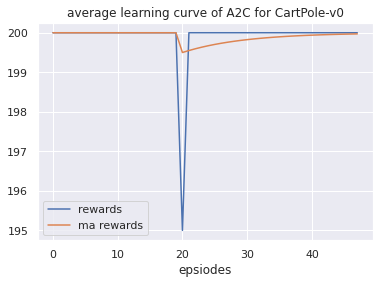

In [81]:
main()